In [1]:
install.packages("caret")
install.packages("e1071")
install.packages("rpart")


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



# Import the needed libraries

In [2]:
list.files(path = "../input/")
library(dplyr)
library(caret)
library(ggplot2)
library(reshape2)
library(tidyverse) 
library(keras) 
library(e1071)
library(rpart)
library(pROC)

[1] "framingham"    "medicalcentre"


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: ggplot2

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:httr’:

    progress


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.1     ✔ tidyr     1.3.0
✔ readr     2.1.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()   masks stats::filter()
✖ dplyr::lag()      masks stats::lag()
✖ purrr::lift()     masks caret::lift()
✖ caret::progress() masks httr::progress()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Type 'citation("pROC")' for a citation.


Attaching package:

# Read the data

In [3]:
directory_path <- "/kaggle/input/medicalcentre"
file_list <- list.files(directory_path, pattern = ".csv", full.names = TRUE)
chosen_file <- file_list[1]
data <- read.csv(chosen_file)

head(data)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No.show
,<dbl>,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>
1,2.98725e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
2,5.58998e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
3,4.26296e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
4,8.67951e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
5,8.84119e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No
6,9.59851e+13,5626772,F,2016-04-27T08:36:51Z,2016-04-29T00:00:00Z,76,REPÚBLICA,0,1,0,0,0,0,No


## Part 1) A-

### 1- Check for the NULL values

In [4]:
dim(data)

[1] 110527     14

In [5]:
null_values <- sum(is.na(data))

# Print the number of null values
print(null_values)

[1] 3


In [6]:
data <- na.omit(data)
head(data)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No.show
,<dbl>,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>
1,2.98725e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
2,5.58998e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
3,4.26296e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
4,8.67951e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
5,8.84119e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No
6,9.59851e+13,5626772,F,2016-04-27T08:36:51Z,2016-04-29T00:00:00Z,76,REPÚBLICA,0,1,0,0,0,0,No


In [7]:
dim(data)


[1] 110524     14

### 2- Function to boxplot the numerical columns 

In [8]:
# Function to create a boxplot
createBoxplot <- function(col, col_name, title = sprintf("Boxplot of %s Column", col_name), x_label = col_name, color = "skyblue") {
  boxplot(col, main = title, xlab = x_label, col = color)
}


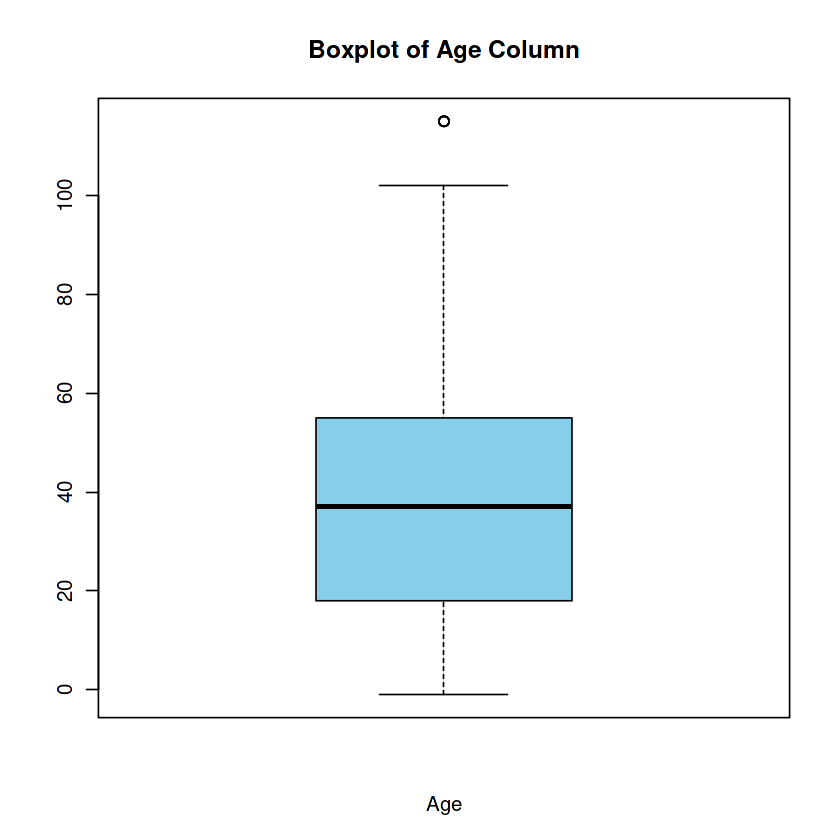

In [9]:
createBoxplot(data$Age , "Age")

### Function to barplot the categorical columns

In [10]:
plot_column <- function(data, column, title) {
  # Check if the column exists in the data frame
  if (!(column %in% colnames(data))) {
    stop("Column '", column, "' does not exist in the data frame.")
  }
  
  # Retrieve the column data
  column_data <- data[[column]]
  
  # Calculate the frequency table
  freq_table <- table(column_data)
  
  # Create the bar plot with light blue color
  barplot(freq_table,
          main = title,
          xlab = column,
          ylab = "Frequency",
          col = "lightblue")
  
  # Add total frequency values on top of each bar
  text(x = barplot(freq_table, plot = FALSE), y = freq_table, labels = freq_table, pos = 3, col = "black")
}


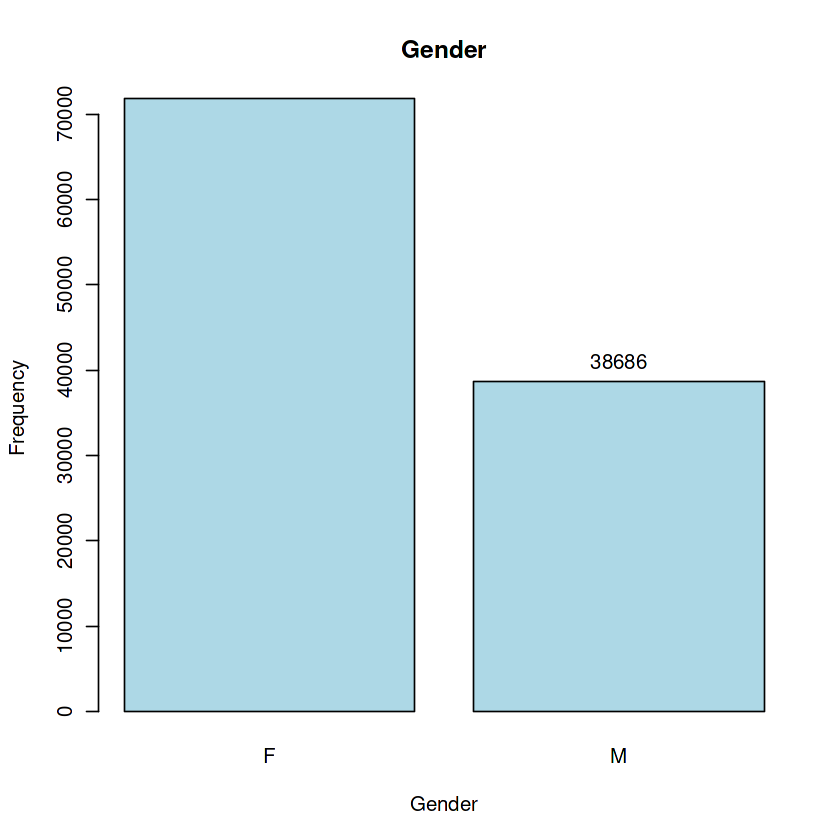

In [11]:
plot_column(data ,"Gender" , "Gender")

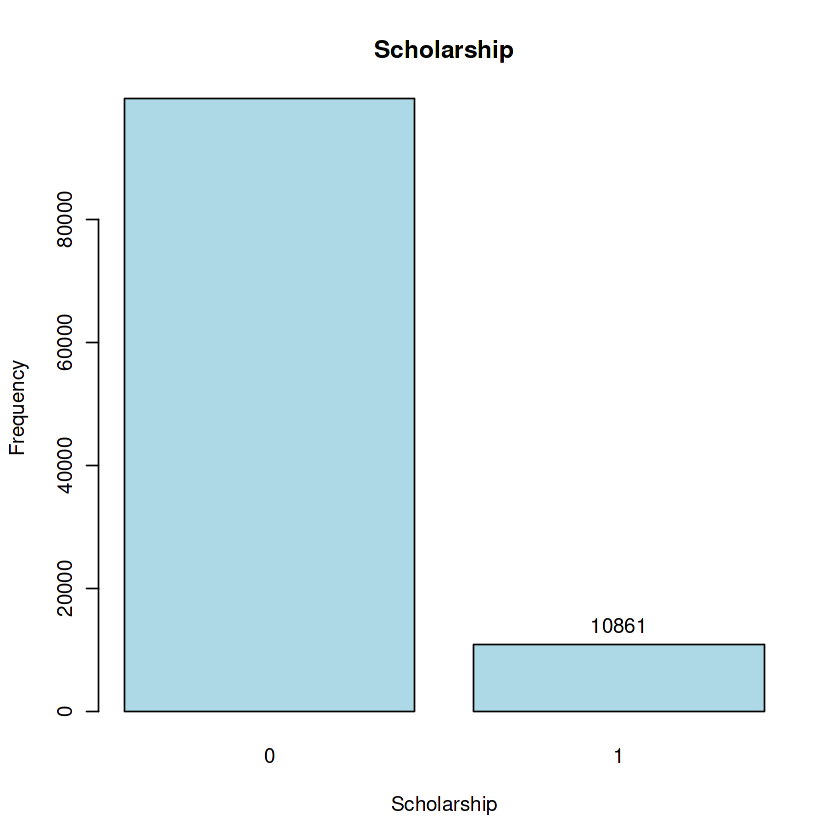

In [12]:
plot_column(data ,"Scholarship" , "Scholarship")

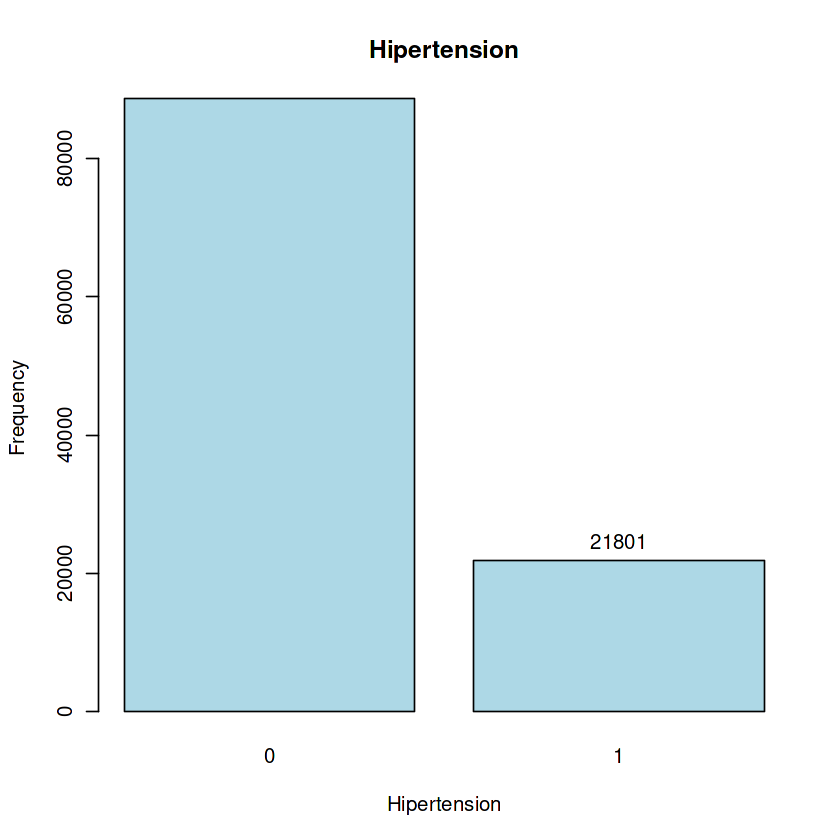

In [13]:
plot_column(data ,"Hipertension" , "Hipertension")

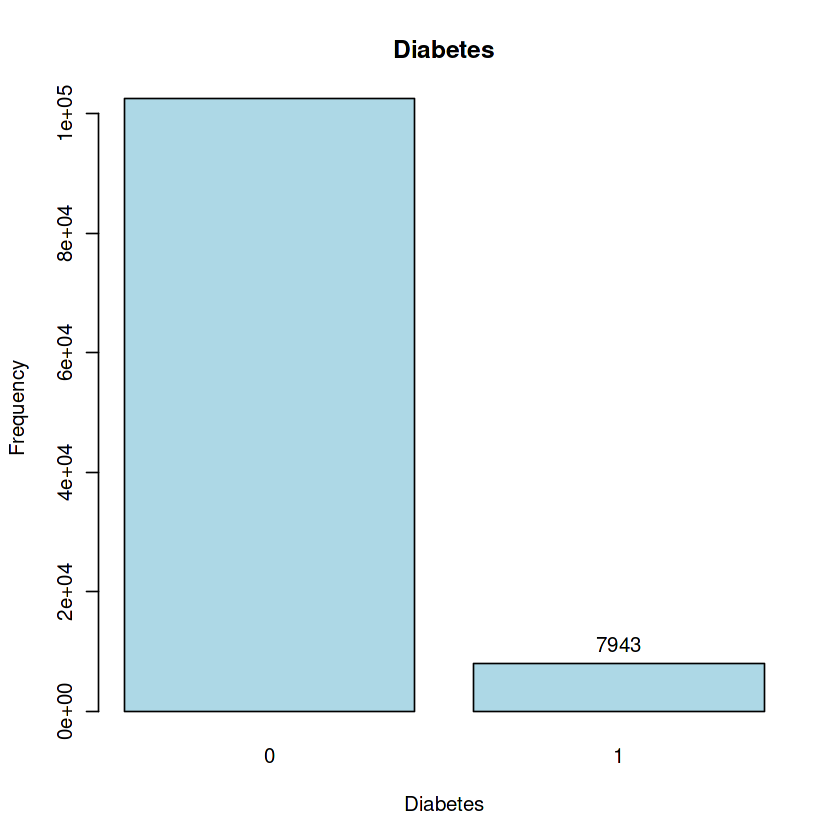

In [14]:
plot_column(data ,"Diabetes" , "Diabetes")

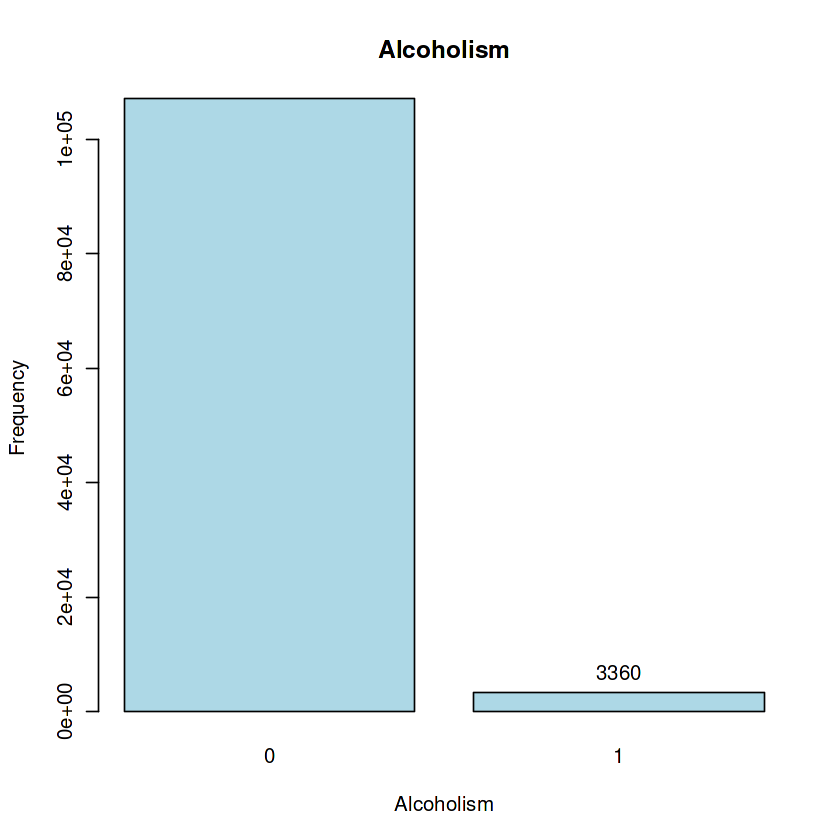

In [15]:
plot_column(data ,"Alcoholism" , "Alcoholism")

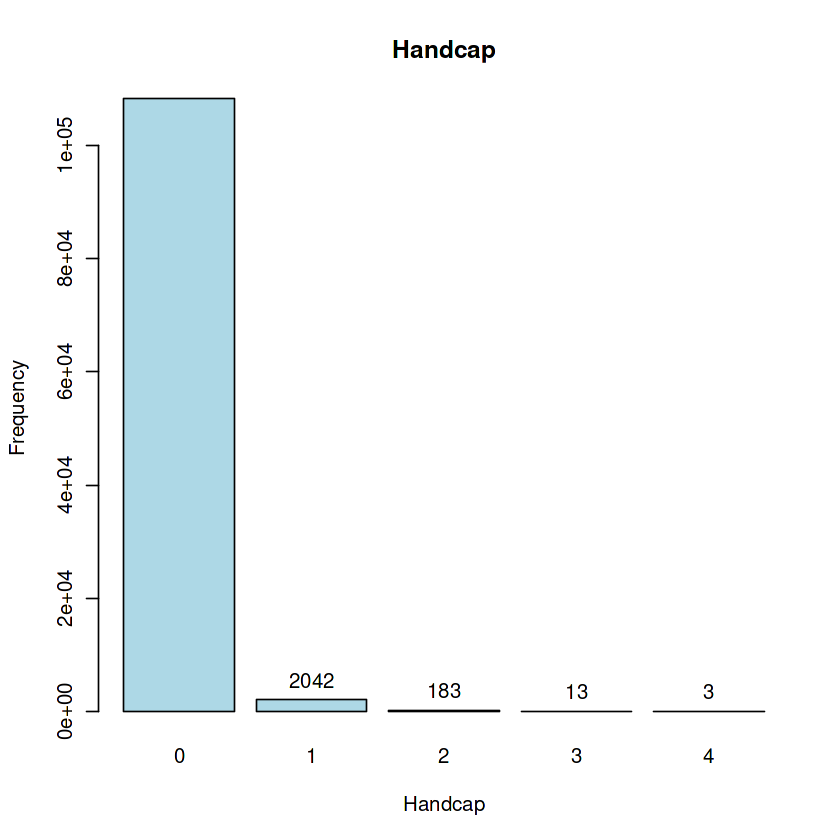

In [16]:
plot_column(data ,"Handcap" , "Handcap")

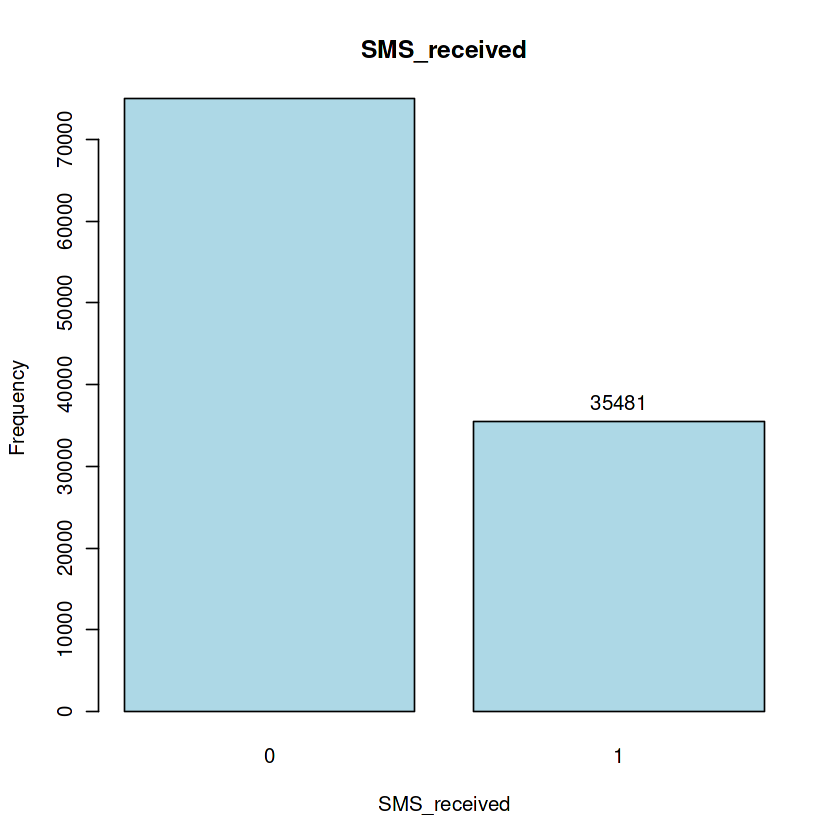

In [17]:
plot_column(data ,"SMS_received" , "SMS_received")

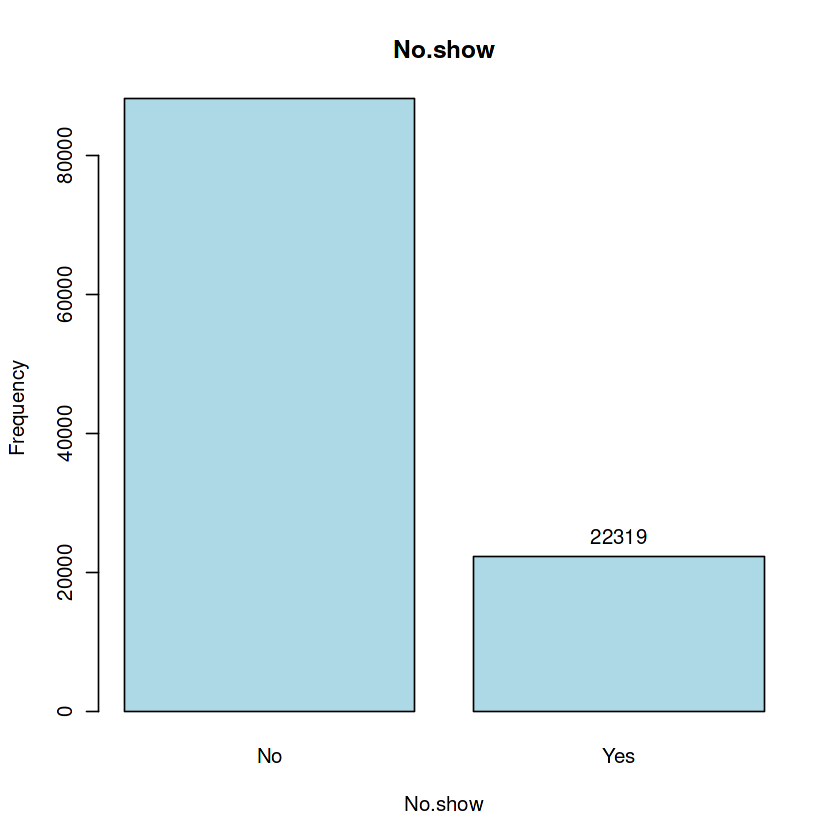

In [18]:
plot_column(data ,"No.show" , "No.show")

### 3- Check for the negative values in the AGE column and remove them 

In [19]:
sum(data$Age < 0)

[1] 1

In [20]:
data <- data[!data$Age < 0, ] 
dim(data)

[1] 110523     14

### 5- Label encoding the needed categorical columns

In [21]:
# Function to label encode a specific column in a dataframe
labelEncode <- function(data, col_name) {
  if (is.character(data[, col_name])) {
    data[, col_name] <- as.integer(factor(data[, col_name]))
  }
  return(data)
}


In [22]:
data = labelEncode(data , "Gender")
data = labelEncode(data , "Neighbourhood")
data = labelEncode(data , "No.show")

In [23]:
head(data)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No.show
,<dbl>,<int>,<int>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,2.98725e+13,5642903,1,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,40,0,1,0,0,0,0,1
2,5.58998e+14,5642503,2,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,40,0,0,0,0,0,0,1
3,4.26296e+12,5642549,1,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,47,0,0,0,0,0,0,1
4,8.67951e+11,5642828,1,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,55,0,0,0,0,0,0,1
5,8.84119e+12,5642494,1,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,40,0,1,1,0,0,0,1
6,9.59851e+13,5626772,1,2016-04-27T08:36:51Z,2016-04-29T00:00:00Z,76,59,0,1,0,0,0,0,1


### Function to count the values in the columns 

In [24]:
# Function to perform value counts on a specific column in a dataframe
valueCounts <- function(data, col_name) {
  counts <- table(data[, col_name])
  return(counts)
}


In [25]:
valueCounts(data , "No.show")


    1     2 
88204 22319 

In [26]:
valueCounts(data , "Gender")


    1     2 
71837 38686 

### 6- Separate the date columns to its components

In [27]:
# Function to separate datetime components in a specified column of a dataframe
separateDatetime <- function(data, column) {
  
  
  data <- data %>% 
    mutate(!!paste0(column, "_Date") := as.Date(.data[[column]], format = "%Y-%m-%d"),
           !!paste0(column, "_Year") := lubridate::year(.data[[column]]),
           !!paste0(column, "_Month") := lubridate::month(.data[[column]]),
           !!paste0(column, "_Day") := lubridate::day(.data[[column]]))
           
  
  return(data)
}


In [28]:
data = separateDatetime(data , "AppointmentDay")

In [29]:
data = separateDatetime(data , "ScheduledDay")

In [30]:
head(data)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,⋯,SMS_received,No.show,AppointmentDay_Date,AppointmentDay_Year,AppointmentDay_Month,AppointmentDay_Day,ScheduledDay_Date,ScheduledDay_Year,ScheduledDay_Month,ScheduledDay_Day
,<dbl>,<int>,<int>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<date>,<dbl>,<dbl>,<int>,<date>,<dbl>,<dbl>,<int>
1,2.98725e+13,5642903,1,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,40,0,1,0,⋯,0,1,2016-04-29,2016,4,29,2016-04-29,2016,4,29
2,5.58998e+14,5642503,2,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,40,0,0,0,⋯,0,1,2016-04-29,2016,4,29,2016-04-29,2016,4,29
3,4.26296e+12,5642549,1,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,47,0,0,0,⋯,0,1,2016-04-29,2016,4,29,2016-04-29,2016,4,29
4,8.67951e+11,5642828,1,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,55,0,0,0,⋯,0,1,2016-04-29,2016,4,29,2016-04-29,2016,4,29
5,8.84119e+12,5642494,1,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,40,0,1,1,⋯,0,1,2016-04-29,2016,4,29,2016-04-29,2016,4,29
6,9.59851e+13,5626772,1,2016-04-27T08:36:51Z,2016-04-29T00:00:00Z,76,59,0,1,0,⋯,0,1,2016-04-29,2016,4,29,2016-04-27,2016,4,27


### 4- Derive the awaitingtime column from the appointment day & schedule day

In [33]:
# Calculate the waiting time (duration) between 'AppointmentDay' and 'ScheduledDay'
data$AwaitingTime <- as.numeric(data$AppointmentDay_Date - data$ScheduledDay_Date)

# Transform negative waiting times into positive values
data$AwaitingTime <- abs(data$AwaitingTime)

### 7- Normalize the age column with MinMaxNormalization to be between 0 and 1

In [31]:
minMaxNormalize <- function(data, column) {
  # Create a temporary data frame with column names
  temp_data <- data.frame(Val = data[[column]])
  
  # Apply min-max normalization
  normalized_column <- preProcess(temp_data, method = "range", range = c(0, 1))
  
  # Replace the column data with the normalized values
  data[[column]] <- predict(normalized_column, newdata = temp_data)$Val
  
  return(data)
}

In [32]:
data = minMaxNormalize(data ,"Age")
head(data)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,⋯,SMS_received,No.show,AppointmentDay_Date,AppointmentDay_Year,AppointmentDay_Month,AppointmentDay_Day,ScheduledDay_Date,ScheduledDay_Year,ScheduledDay_Month,ScheduledDay_Day
,<dbl>,<int>,<int>,<chr>,<chr>,<dbl>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<date>,<dbl>,<dbl>,<int>,<date>,<dbl>,<dbl>,<int>
1,2.98725e+13,5642903,1,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,0.53913043,40,0,1,0,⋯,0,1,2016-04-29,2016,4,29,2016-04-29,2016,4,29
2,5.58998e+14,5642503,2,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,0.48695652,40,0,0,0,⋯,0,1,2016-04-29,2016,4,29,2016-04-29,2016,4,29
3,4.26296e+12,5642549,1,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,0.53913043,47,0,0,0,⋯,0,1,2016-04-29,2016,4,29,2016-04-29,2016,4,29
4,8.67951e+11,5642828,1,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,0.06956522,55,0,0,0,⋯,0,1,2016-04-29,2016,4,29,2016-04-29,2016,4,29
5,8.84119e+12,5642494,1,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,0.48695652,40,0,1,1,⋯,0,1,2016-04-29,2016,4,29,2016-04-29,2016,4,29
6,9.59851e+13,5626772,1,2016-04-27T08:36:51Z,2016-04-29T00:00:00Z,0.66086957,59,0,1,0,⋯,0,1,2016-04-29,2016,4,29,2016-04-27,2016,4,27


In [34]:
# Function to drop a specific column from a dataframe
dropColumn <- function(data, column) {
  new_data <- data[, !colnames(data) %in% column]
  return(new_data)
}


In [35]:
colnames(data)

[1] "PatientId"            "AppointmentID"        "Gender"              
 [4] "ScheduledDay"         "AppointmentDay"       "Age"                 
 [7] "Neighbourhood"        "Scholarship"          "Hipertension"        
[10] "Diabetes"             "Alcoholism"           "Handcap"             
[13] "SMS_received"         "No.show"              "AppointmentDay_Date" 
[16] "AppointmentDay_Year"  "AppointmentDay_Month" "AppointmentDay_Day"  
[19] "ScheduledDay_Date"    "ScheduledDay_Year"    "ScheduledDay_Month"  
[22] "ScheduledDay_Day"     "AwaitingTime"

In [36]:
data = dropColumn(data , "PatientId")
data = dropColumn(data , "AppointmentID")
data = dropColumn(data , "ScheduledDay")
data = dropColumn(data , "AppointmentDay")
data = dropColumn(data , "ScheduledDay_Date")
data = dropColumn(data , "AppointmentDay_Date")

head(data)

,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No.show,AppointmentDay_Year,AppointmentDay_Month,AppointmentDay_Day,ScheduledDay_Year,ScheduledDay_Month,ScheduledDay_Day,AwaitingTime
,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>
1,1,0.53913043,40,0,1,0,0,0,0,1,2016,4,29,2016,4,29,0
2,2,0.48695652,40,0,0,0,0,0,0,1,2016,4,29,2016,4,29,0
3,1,0.53913043,47,0,0,0,0,0,0,1,2016,4,29,2016,4,29,0
4,1,0.06956522,55,0,0,0,0,0,0,1,2016,4,29,2016,4,29,0
5,1,0.48695652,40,0,1,1,0,0,0,1,2016,4,29,2016,4,29,0
6,1,0.66086957,59,0,1,0,0,0,0,1,2016,4,29,2016,4,27,2


### 8- Plot heatmap to display the correlation between features 

In [37]:
correlation_heatmap <- function(data) {
  # Check for zero standard deviations
  zero_sd_columns <- sapply(data, function(x) sd(x) == 0)
  zero_sd_columns <- names(zero_sd_columns)[zero_sd_columns]
  
  if (length(zero_sd_columns) > 0) {
    warning(paste("Column(s) with zero standard deviation:", paste(zero_sd_columns, collapse = ", ")))
    data <- data[, !names(data) %in% zero_sd_columns]
  }
  
  correlation_matrix <- cor(data)
  
  
  correlation_df <- reshape2::melt(correlation_matrix)
  
  options(repr.plot.width = 20, repr.plot.height = 20)
  
  ggplot(correlation_df, aes(Var2, Var1, fill = value)) +
    geom_tile() +
    geom_text(aes(label = round(value, 2)), color = "black", size = 5) +
    scale_fill_gradient2(low = "#BBDEFB", high = "#0D47A1", mid = "white",
                         midpoint = 0, limit = c(-1, 1),
                         name = "Correlation") +
    theme_minimal() +
    labs(x = "", y = "",
         title = "Correlation Heatmap") +
    theme(plot.title = element_text(size = 16, face = "bold"),
          axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1, size = 15),
          axis.text.y = element_text(size = 15),
          axis.title = element_blank(),
          legend.position = "right",
          legend.title = element_text(size = 12, face = "bold"),
          legend.text = element_text(size = 10),
          plot.background = element_rect(fill = "white")) +
    coord_equal(ratio = 0.5)+
    theme(plot.background = element_rect(fill = "white"),
          panel.grid = element_blank(),
          panel.border = element_blank(),
          panel.background = element_rect(fill = "white"),
          panel.spacing = unit(20, "mm")) +
    theme(plot.background = element_rect(fill = "white"))
}




In [38]:
head(data,5)

,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No.show,AppointmentDay_Year,AppointmentDay_Month,AppointmentDay_Day,ScheduledDay_Year,ScheduledDay_Month,ScheduledDay_Day,AwaitingTime
,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>
1,1,0.53913043,40,0,1,0,0,0,0,1,2016,4,29,2016,4,29,0
2,2,0.48695652,40,0,0,0,0,0,0,1,2016,4,29,2016,4,29,0
3,1,0.53913043,47,0,0,0,0,0,0,1,2016,4,29,2016,4,29,0
4,1,0.06956522,55,0,0,0,0,0,0,1,2016,4,29,2016,4,29,0
5,1,0.48695652,40,0,1,1,0,0,0,1,2016,4,29,2016,4,29,0


Warning message in correlation_heatmap(data):
“Column(s) with zero standard deviation: AppointmentDay_Year”


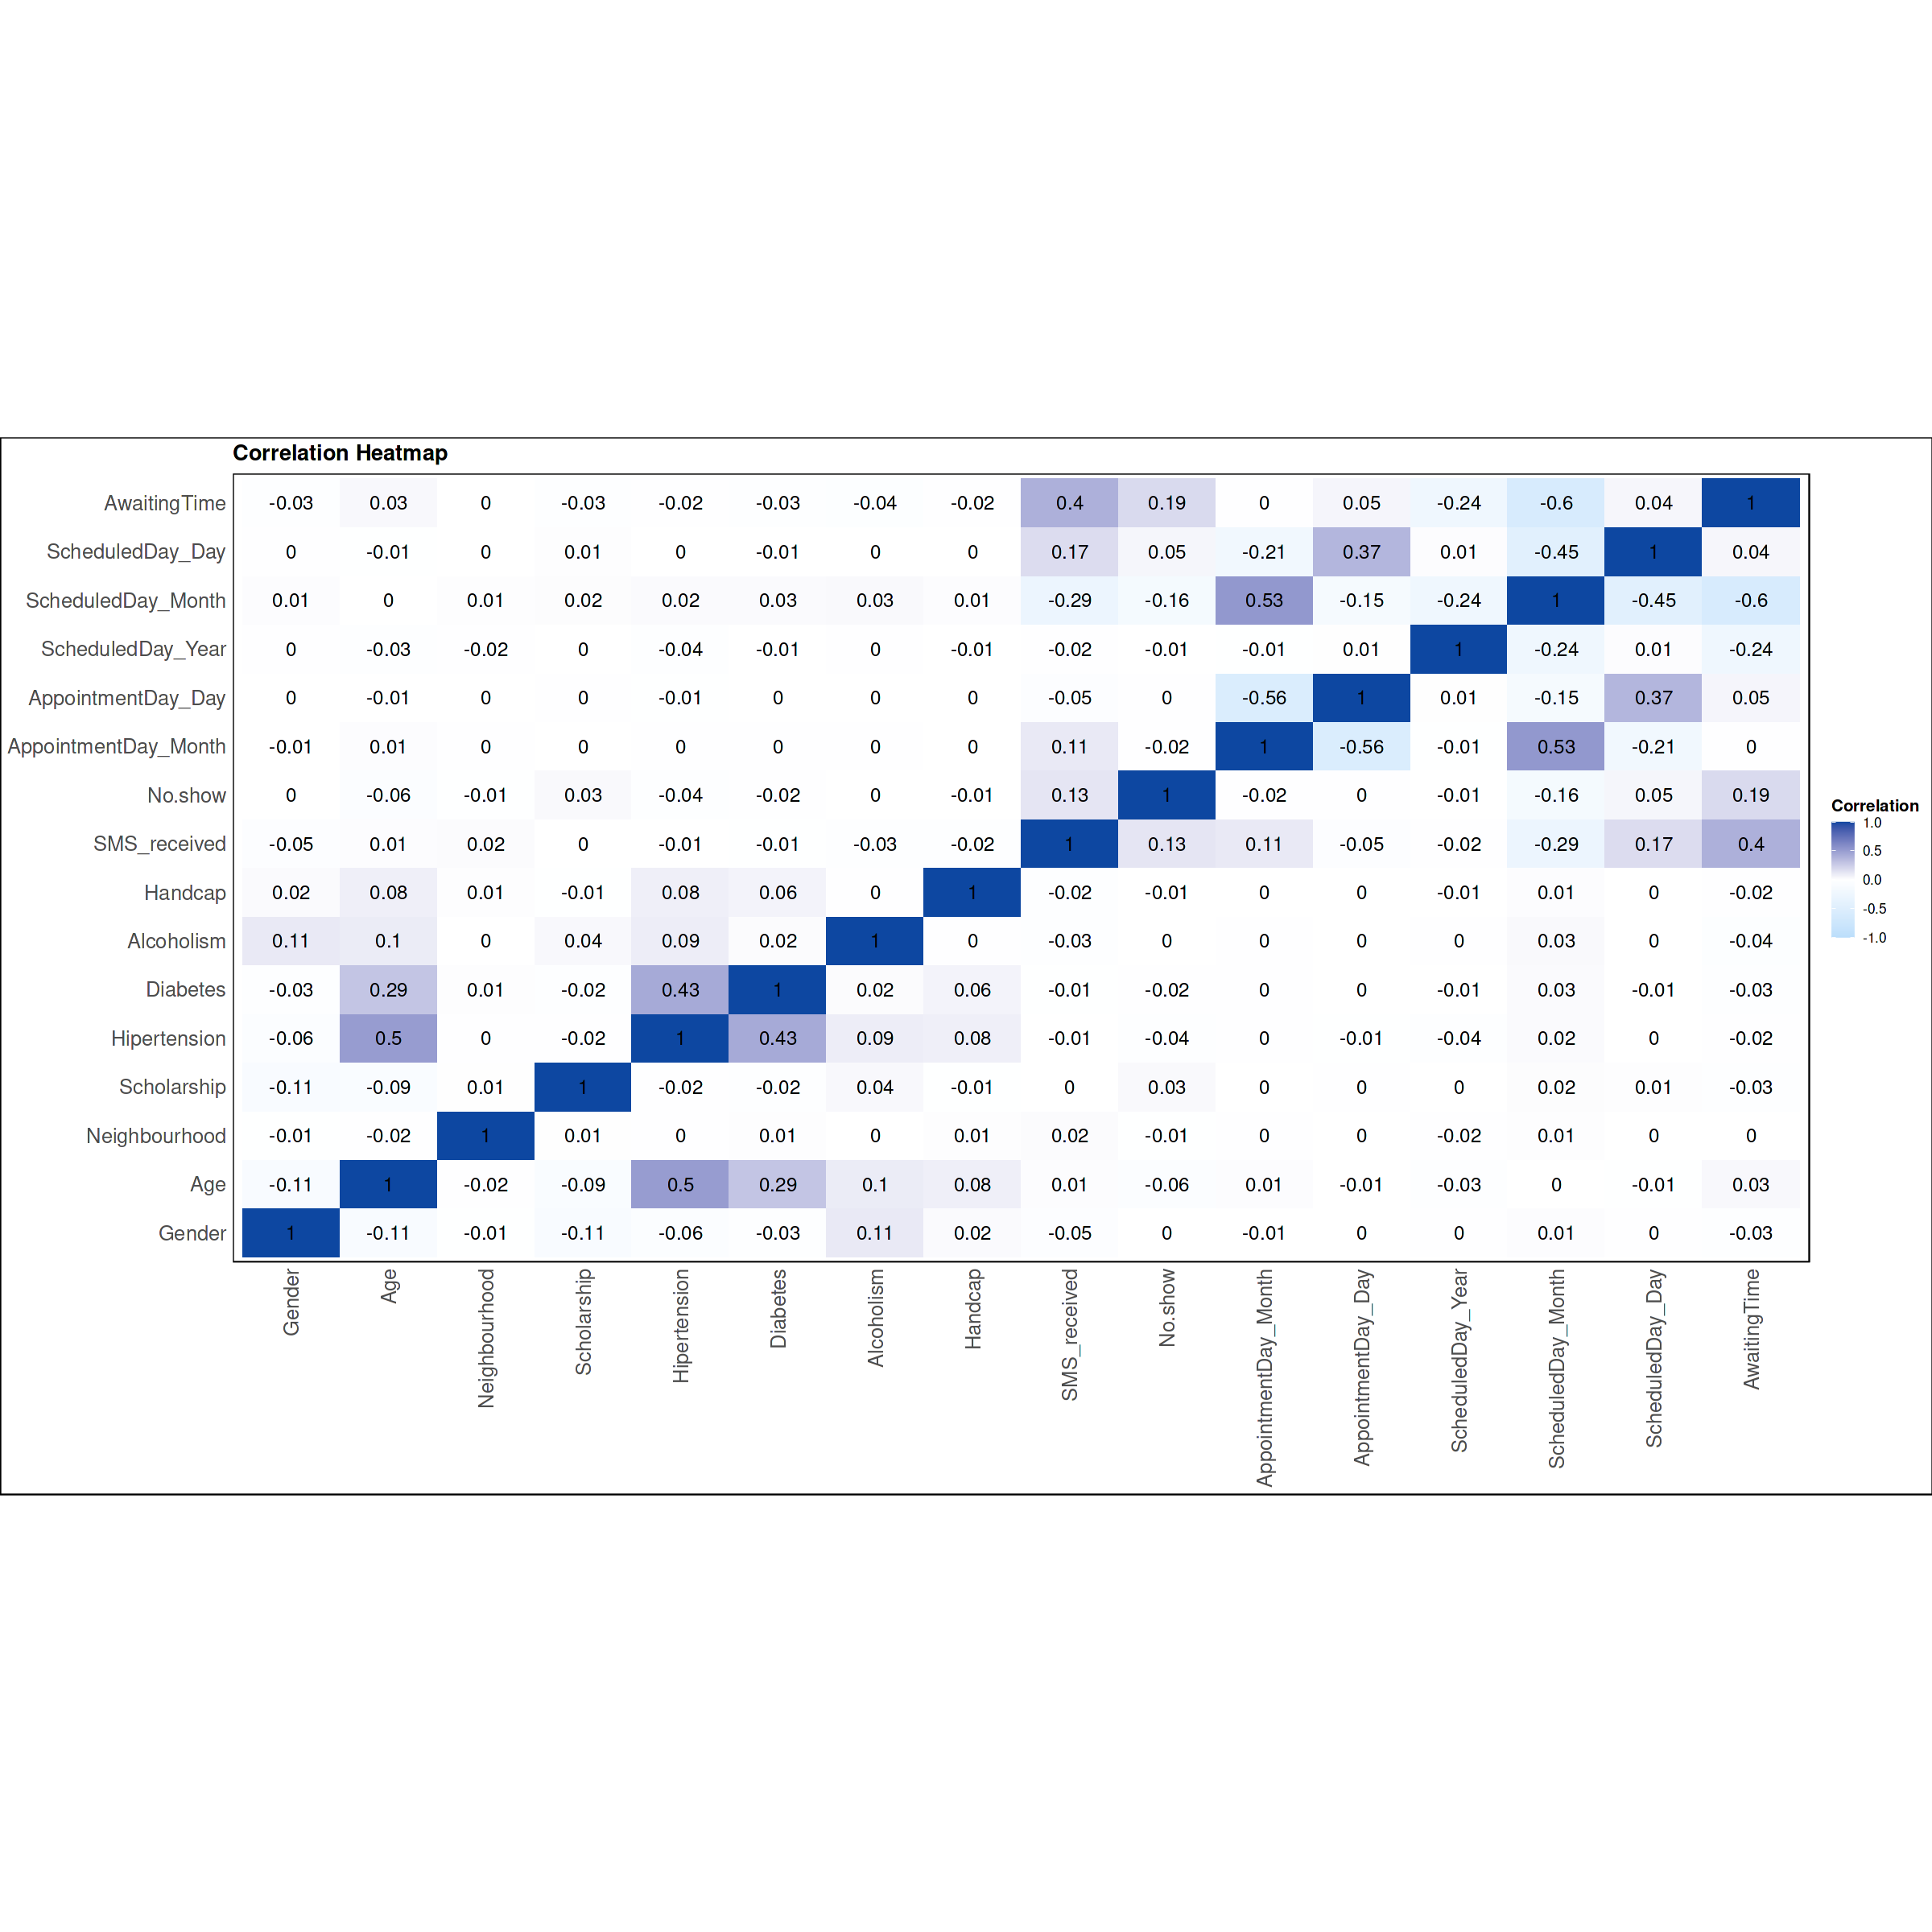

In [39]:
correlation_heatmap(data)

### Drop the correlated features from the data

In [40]:
data = dropColumn(data , "AppointmentDay_Day")
data = dropColumn(data , "AppointmentDay_Month")
data = dropColumn(data , "ScheduledDay_Month")

In [41]:
head(data,5)

,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No.show,AppointmentDay_Year,ScheduledDay_Year,ScheduledDay_Day,AwaitingTime
,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>
1,1,0.53913043,40,0,1,0,0,0,0,1,2016,2016,29,0
2,2,0.48695652,40,0,0,0,0,0,0,1,2016,2016,29,0
3,1,0.53913043,47,0,0,0,0,0,0,1,2016,2016,29,0
4,1,0.06956522,55,0,0,0,0,0,0,1,2016,2016,29,0
5,1,0.48695652,40,0,1,1,0,0,0,1,2016,2016,29,0


In [42]:
data = dropColumn(data , "AppointmentDay_Year")
data = dropColumn(data , "ScheduledDay_Year")

In [43]:
head(data,5)

,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No.show,ScheduledDay_Day,AwaitingTime
,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
1,1,0.53913043,40,0,1,0,0,0,0,1,29,0
2,2,0.48695652,40,0,0,0,0,0,0,1,29,0
3,1,0.53913043,47,0,0,0,0,0,0,1,29,0
4,1,0.06956522,55,0,0,0,0,0,0,1,29,0
5,1,0.48695652,40,0,1,1,0,0,0,1,29,0


In [44]:
data$No.show <- as.factor(data$No.show)
data$Neighbourhood <- as.factor(data$Neighbourhood)
data$Gender <- as.factor(data$Gender)

In [45]:
dim(data)

[1] 110523     12

In [46]:
str(data)

'data.frame':	110523 obs. of  12 variables:
 $ Gender          : Factor w/ 2 levels "1","2": 1 2 1 1 1 1 1 1 1 1 ...
 $ Age             : num  0.5391 0.487 0.5391 0.0696 0.487 ...
 $ Neighbourhood   : Factor w/ 81 levels "1","2","3","4",..: 40 40 47 55 40 59 26 26 2 13 ...
 $ Scholarship     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Hipertension    : int  1 0 0 0 1 1 0 0 0 0 ...
 $ Diabetes        : int  0 0 0 0 1 0 0 0 0 0 ...
 $ Alcoholism      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Handcap         : int  0 0 0 0 0 0 0 0 0 0 ...
 $ SMS_received    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ No.show         : Factor w/ 2 levels "1","2": 1 1 1 1 1 1 2 2 1 1 ...
 $ ScheduledDay_Day: int  29 29 29 29 29 27 27 27 29 27 ...
 $ AwaitingTime    : num  0 0 0 0 0 2 2 2 0 2 ...


### Split the data to X & Y

In [47]:
Y <- data$No.show
X <- dropColumn(data , "No.show")



dim(X)
length(Y)

[1] 110523     11

[1] 110523

In [48]:
head(X)

,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,ScheduledDay_Day,AwaitingTime
,<fct>,<dbl>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
1,1,0.53913043,40,0,1,0,0,0,0,29,0
2,2,0.48695652,40,0,0,0,0,0,0,29,0
3,1,0.53913043,47,0,0,0,0,0,0,29,0
4,1,0.06956522,55,0,0,0,0,0,0,29,0
5,1,0.48695652,40,0,1,1,0,0,0,29,0
6,1,0.66086957,59,0,1,0,0,0,0,27,2


### Split the X & Y to train and test sets

In [102]:
set.seed(123)

# Perform train-test split
train_index <- createDataPartition(Y, p = 0.7, list = FALSE)

# Create the training and testing datasets
X_train <- X[train_index, ]
Y_train <- Y[train_index]
X_test <- X[-train_index, ]
Y_test <- Y[-train_index]
dim(X_train)
length(Y_train)
dim(X_test)
length(Y_test)

[1] 77367    11

[1] 77367

[1] 33156    11

[1] 33156

In [50]:
table(Y_train)

Y_train
    1     2 
61743 15624 

## D) 

### 1- Function to detect the accuracy  

In [51]:
calculate_accuracy <- function(model, X_train, y_train, X_test, y_test,tree) {

if(tree==1){
DTree_predictions_train<- predict(model, X_train, type = "class")
DTree_predictions_test<- predict(model, X_test, type = "class")


 # Calculate the accuracy
accuracy_train <- sum(DTree_predictions_train == y_train) / length(y_train)
accuracy_test <- sum(DTree_predictions_test == y_test) / length(y_test)

}
else{
     # Predict the labels for the testing dataset
  y_pred_train <- predict(model, newdata = X_train)
  y_pred_test <- predict(model, newdata = X_test)
     # Calculate the accuracy
  accuracy_train <- sum(y_pred_train == y_train) / length(y_train)
  accuracy_test <- sum(y_pred_test == y_test) / length(y_test)
}
 
  # Check for overfitting
  overfitting <- ifelse(accuracy_train > accuracy_test, TRUE, FALSE)
  
  # Return accuracy, overfitting result, and training accuracy
  return(list(accuracy_train = accuracy_train, accuracy_test = accuracy_test, overfitting = overfitting))
}

# SVM

## B)  

### 1- Code the SVM model and predict the test set and print its predictions count and the accuracy

In [52]:
svm_model <- svm(Y_train ~ ., data = X_train, kernel = "linear")
svm_predictions <- predict(svm_model, newdata = X_test)

svm_accuracy <- sum(svm_predictions == Y_test) / length(Y_test)
print(paste("SVM Accuracy:", svm_accuracy))

print(table(svm_predictions))

[1] "SVM Accuracy: 0.79810592351309"
svm_predictions
    1     2 
33155     1 


## D) 3- Evaluate the model and print the accuracy & Sensitivity & Specificity and check for overfitting 

In [60]:
# Calculate the accuracy, sensitivity and specificity of each model
svm_accuracy <- sum(y_pred_prob == Y_test) / length(Y_test)
svm_sensitivity <- sum(y_pred_prob == 1 & Y_test == 1) / sum(Y_test == 1)
svm_specificity <- sum(y_pred_prob == 0 & Y_test == 0) / sum(Y_test == 0)

# Print the results
cat("Model\tAccuracy\tSensitivity\tSpecificity\n")
cat("SVM\t", svm_accuracy, "\t", svm_sensitivity, "\t\t", svm_specificity, "\n")



Model	Accuracy	Sensitivity	Specificity
SVM	 0.7981059 	 1 		 NaN 


### It appears here there is no overfitting but my understanding it is biased towards the majority class due to class imbalance

In [53]:
# Example usage with SVM classifier
svm_accuracy_result <- calculate_accuracy(svm_model, X_train, Y_train, X_test, Y_test,0)
print(paste("SVM Classifier Training Accuracy:", svm_accuracy_result$accuracy_train))
print(paste("SVM Classifier Testing Accuracy:", svm_accuracy_result$accuracy_test))
print(paste("Overfitting Detected:", svm_accuracy_result$overfitting))

[1] "SVM Classifier Training Accuracy: 0.798066359041969"
[1] "SVM Classifier Testing Accuracy: 0.79810592351309"
[1] "Overfitting Detected: FALSE"


## D) 4- Display the ROC curve

Setting levels: control = 1, case = 2

Setting direction: controls < cases



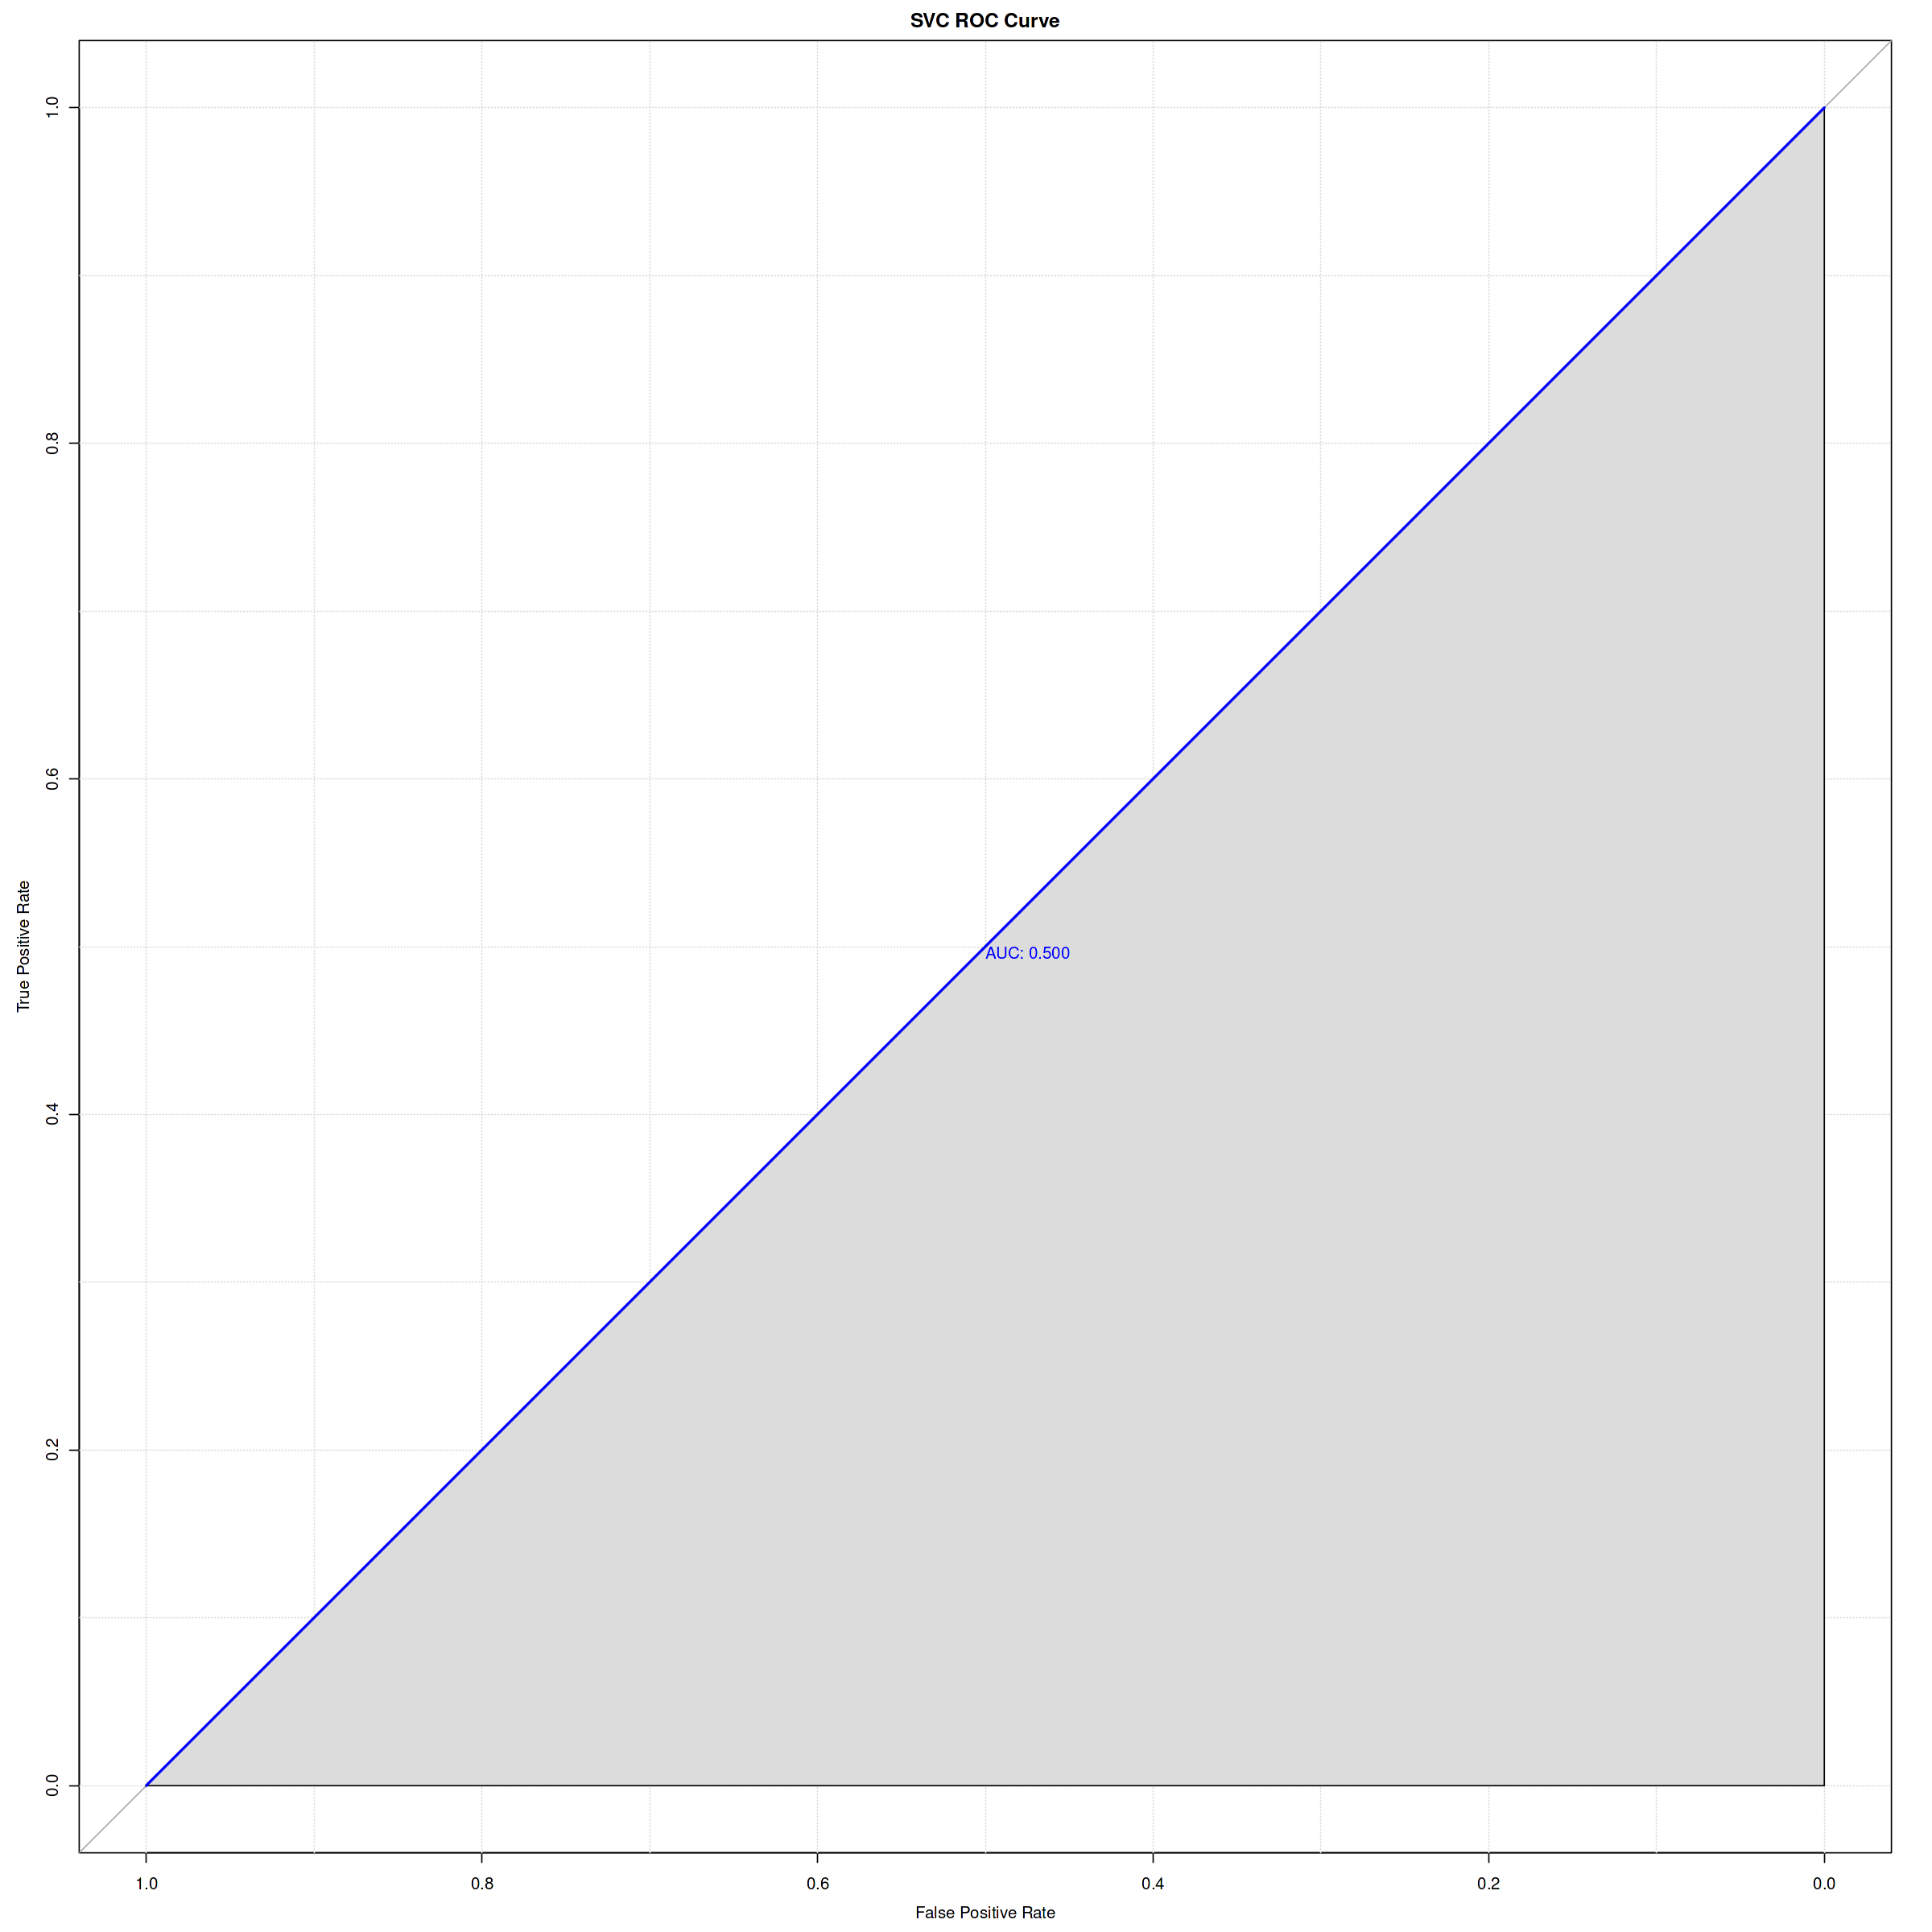

In [55]:
# Create the ROC curve
y_pred_prob <- as.numeric(svm_predictions)
roc_obj <- roc(Y_test, y_pred_prob)
plot(roc_obj, main = "SVC ROC Curve", print.auc = TRUE, auc.polygon = TRUE,
     grid = TRUE, col = "blue", lwd = 2, lty = 1,
     xlab = "False Positive Rate", ylab = "True Positive Rate")

# Decision Tree

### 1- Code the Decision Tree model and predict the test set and print its predictions count and the accuracy

In [61]:
Y_train <- as.factor(Y_train)
Y_test <- as.factor(Y_test)

tree_model <- rpart(Y_train ~ ., data = X_train)
tree_predictions <- predict(tree_model, newdata = X_test, type = "class")

DT_accuracy <- sum(tree_predictions == Y_test) / length(Y_test)
print(paste("DT Accuracy:", DT_accuracy))

table(tree_predictions)

[1] "DT Accuracy: 0.798075763059476"


tree_predictions
    1     2 
33156     0 

## D) 3- Evaluate the model and print the accuracy & Sensitivity & Specificity and check for overfitting 

In [66]:
dt_accuracy <- sum(tree_predictions == Y_test) / length(Y_test)
dt_sensitivity <- sum(tree_predictions == 1 & Y_test == 1) / sum(Y_test == 1)
dt_specificity <- sum(tree_predictions == 0 & Y_test == 0) / sum(Y_test == 0)

cat("Model\tAccuracy\tSensitivity\tSpecificity\n")
cat("DT\t", dt_accuracy, "\t", dt_sensitivity, "\t\t", dt_specificity, "\n")


Model	Accuracy	Sensitivity	Specificity
DT	 0.7980758 	 1 		 NaN 


### It appears here there is no overfitting but my understanding it is biased towards the majority class due to class imbalance

In [62]:
# Example usage with SVM classifier
tree_accuracy_result <- calculate_accuracy(tree_model, X_train, Y_train, X_test, Y_test,1)
print(paste("Decision Tree Classifier Training Accuracy:", tree_accuracy_result$accuracy_train))
print(paste("Decision Tree Classifier Testing Accuracy:", tree_accuracy_result$accuracy_test))
print(paste("Overfitting Detected:", tree_accuracy_result$overfitting))

[1] "Decision Tree Classifier Training Accuracy: 0.798053433634495"
[1] "Decision Tree Classifier Testing Accuracy: 0.798075763059476"
[1] "Overfitting Detected: FALSE"


## D) 4- Display the ROC curve

Setting levels: control = 1, case = 2

Setting direction: controls < cases



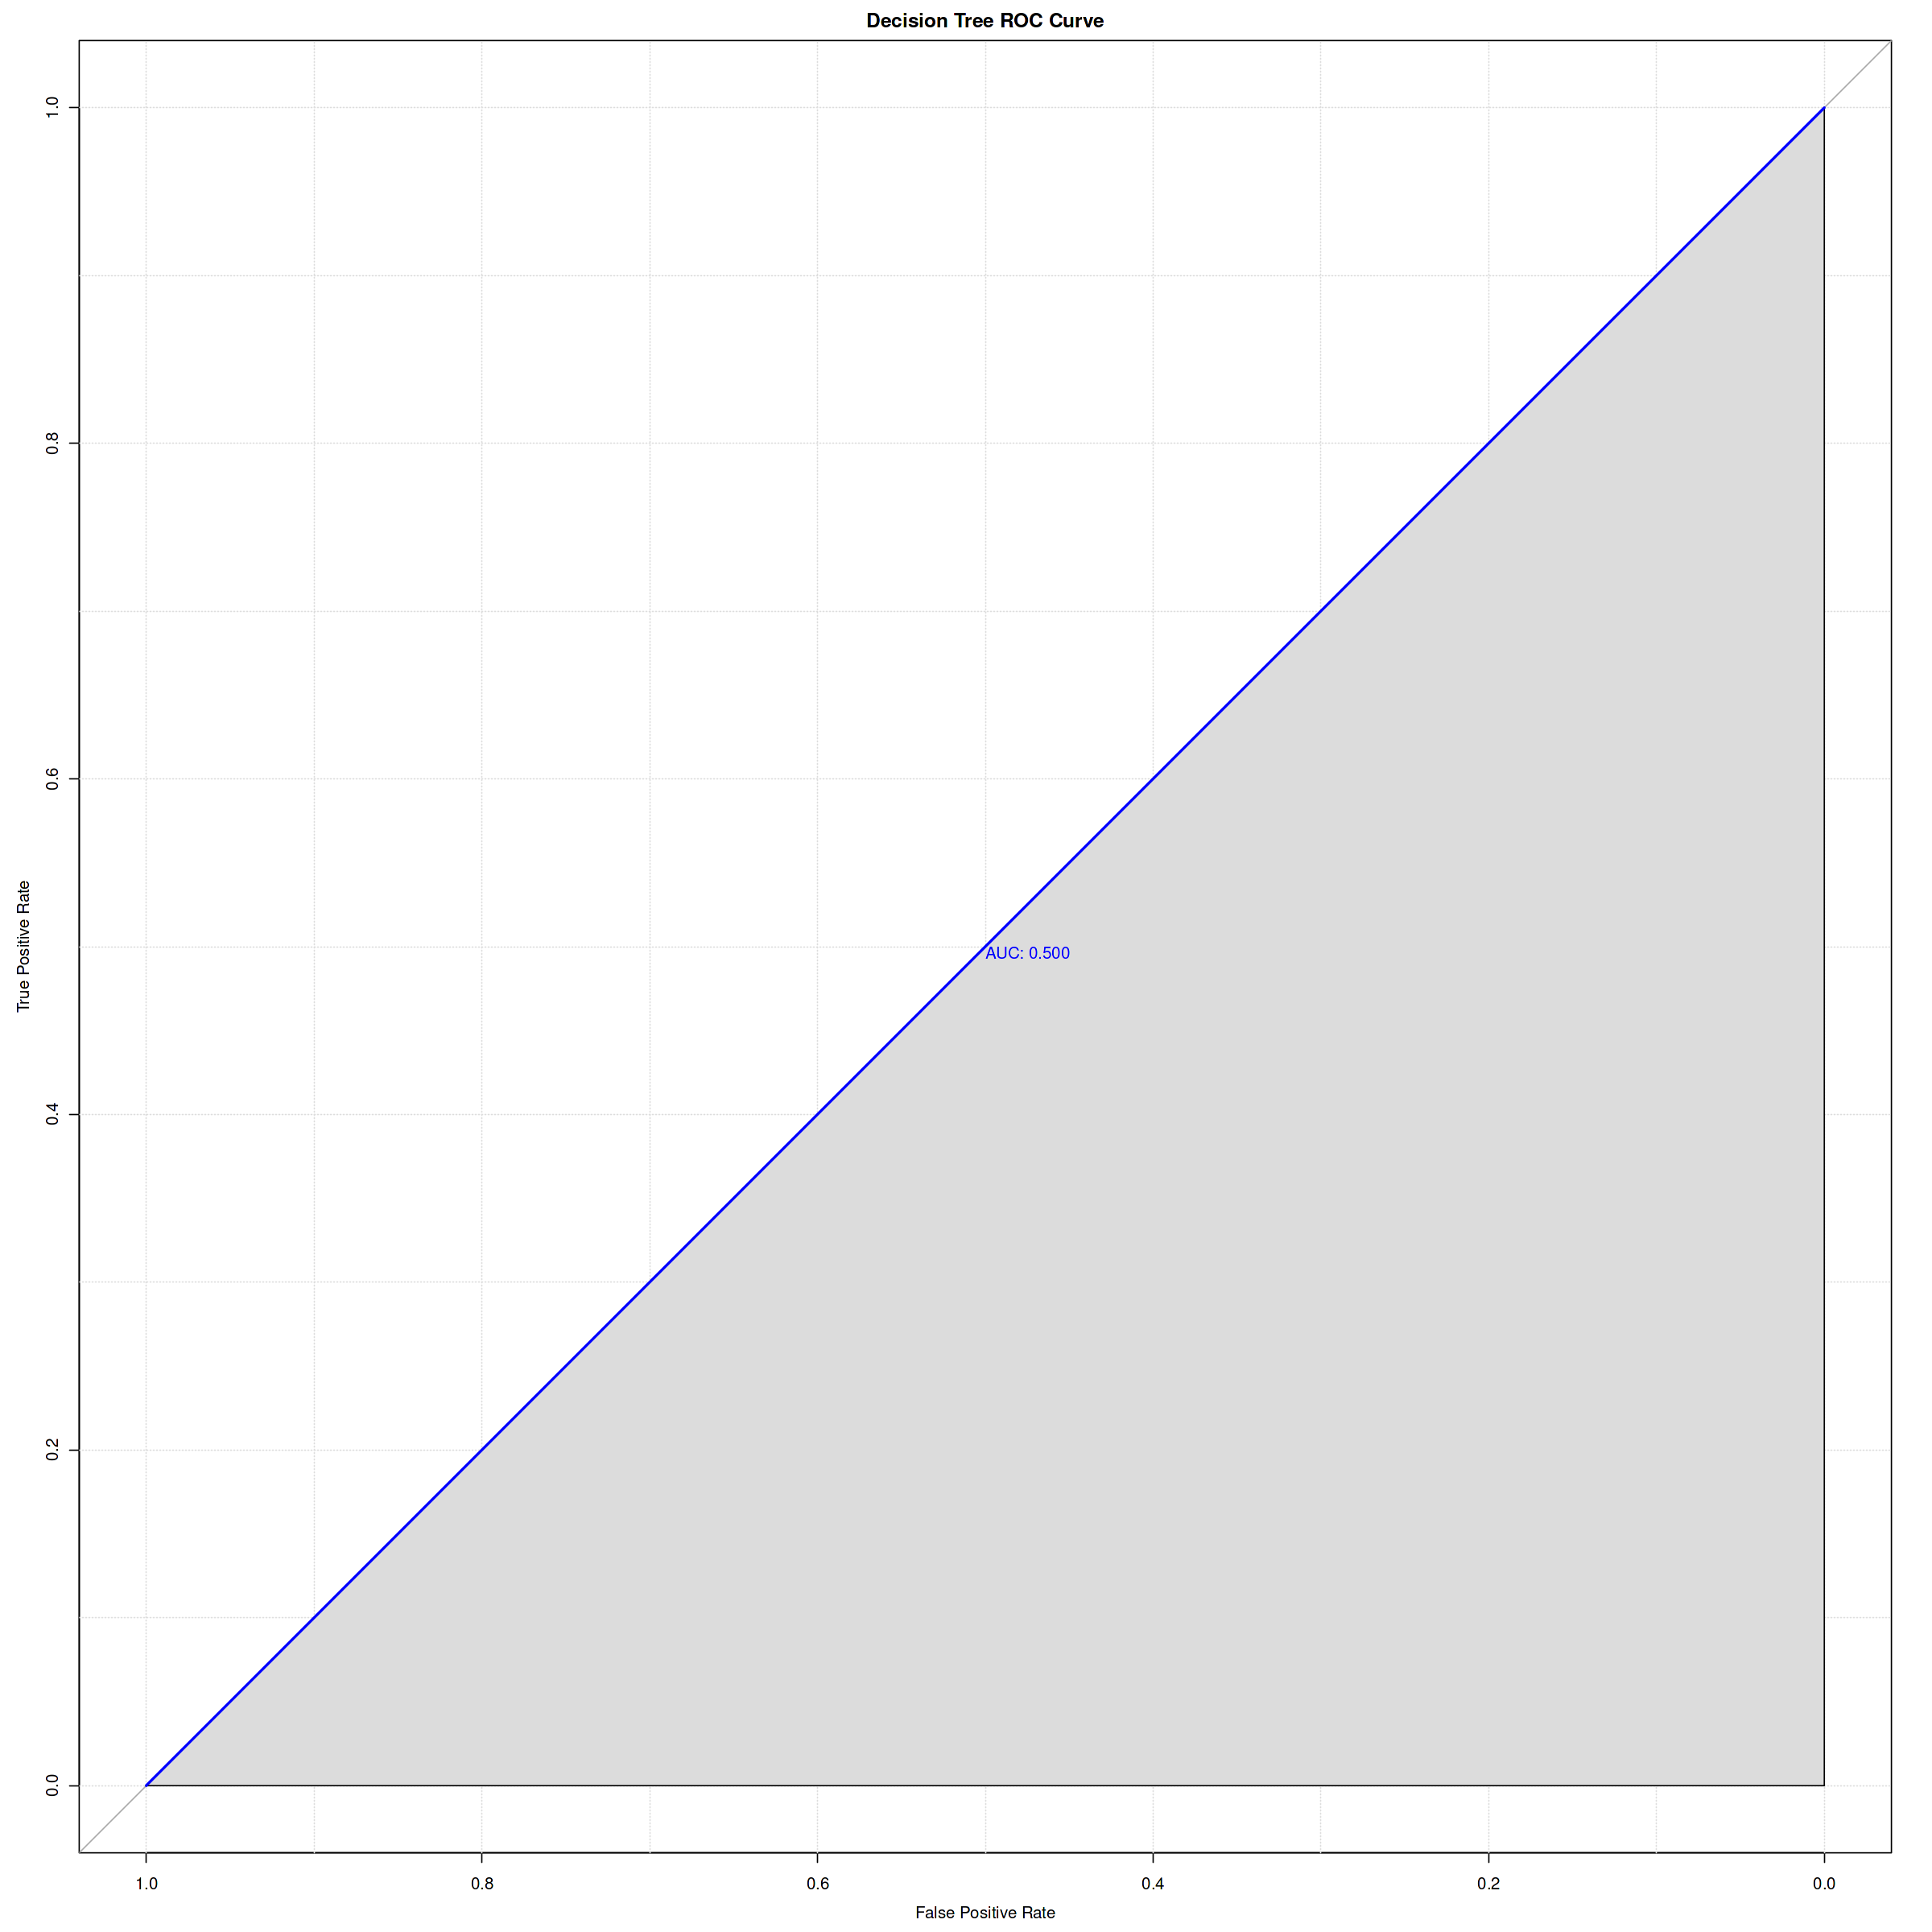

In [69]:
# Create the ROC curve
y_pred_prob <- as.numeric(y_pred_prob)
roc_obj <- roc(Y_test, y_pred_prob)
plot(roc_obj, main = "Decision Tree ROC Curve", print.auc = TRUE, auc.polygon = TRUE,
     grid = TRUE, col = "blue", lwd = 2, lty = 1,
     xlab = "False Positive Rate", ylab = "True Positive Rate")


# Neural Network

In [103]:
X_train<- apply(X_train,2,as.numeric)
X_test<- apply(X_test,2,as.numeric)

Y_train<-to_categorical(Y_train,10)
Y_test<-to_categorical(Y_test,10)

## C) Train the deep neural network model 

### Displat the accuracy & Sensitivity & Specificity and check for overfitting

In [110]:
model <- keras_model_sequential()
model %>%
  layer_dense(units = 5, input_shape = 11) %>%
  layer_dropout(rate=0.4)%>%
  layer_dense(units = 3) %>%
  layer_activation(activation = 'relu') %>%
  layer_dense(units = 2) %>%
  layer_dense(units = 10) %>%
  layer_activation(activation = 'sigmoid')

model %>% compile(
  loss = 'categorical_crossentropy',
  optimizer = 'adam',
  metrics = c('accuracy')
)

model %>% fit(X_train, Y_train, epochs = 20)

test_pred_prob <- model %>% predict(X_test)
test_pred <- ifelse(test_pred_prob > 0.5, 1, 0)  

nn_accuracy <- sum(test_pred == Y_test) / length(Y_test)
nn_sensitivity <- sum(test_pred == 1 & Y_test == 1) / sum(Y_test == 1)
nn_specificity <- sum(test_pred == 0 & Y_test == 0) / sum(Y_test == 0)

cat("Model\tAccuracy\tSensitivity\tSpecificity\n")
cat("DT\t", nn_accuracy, "\t", nn_sensitivity, "\t\t\t", nn_specificity, "\n")


loss_and_metrics <- model %>% evaluate(X_train, Y_train)
train_accuracy = loss_and_metrics[2]
cat("Neural Network Classifier Training Accuracy: ",train_accuracy)

loss_and_metrics <- model %>% evaluate(X_test, Y_test)
test_accuracy = loss_and_metrics[2]
cat("\n Neural Network Classifier Training Accuracy : ",test_accuracy)

overfitting <- ifelse(train_accuracy > test_accuracy, TRUE, FALSE)
cat("\n Overfitting Detected:", overfitting)

Model	Accuracy	Sensitivity	Specificity
DT	 0.9 	 1 			 0.8888889 
Neural Network Classifier Training Accuracy:  0.7980534
 Neural Network Classifier Training Accuracy :  0.7980757
 Overfitting Detected: FALSE

## D) 4- Display the ROC curve

Setting levels: control = 0, case = 1

Warning message in roc.default(Y_test, y_pred_prob):
“Deprecated use a matrix as response. Unexpected results may be produced, please pass a vector or factor.”
Setting direction: controls < cases



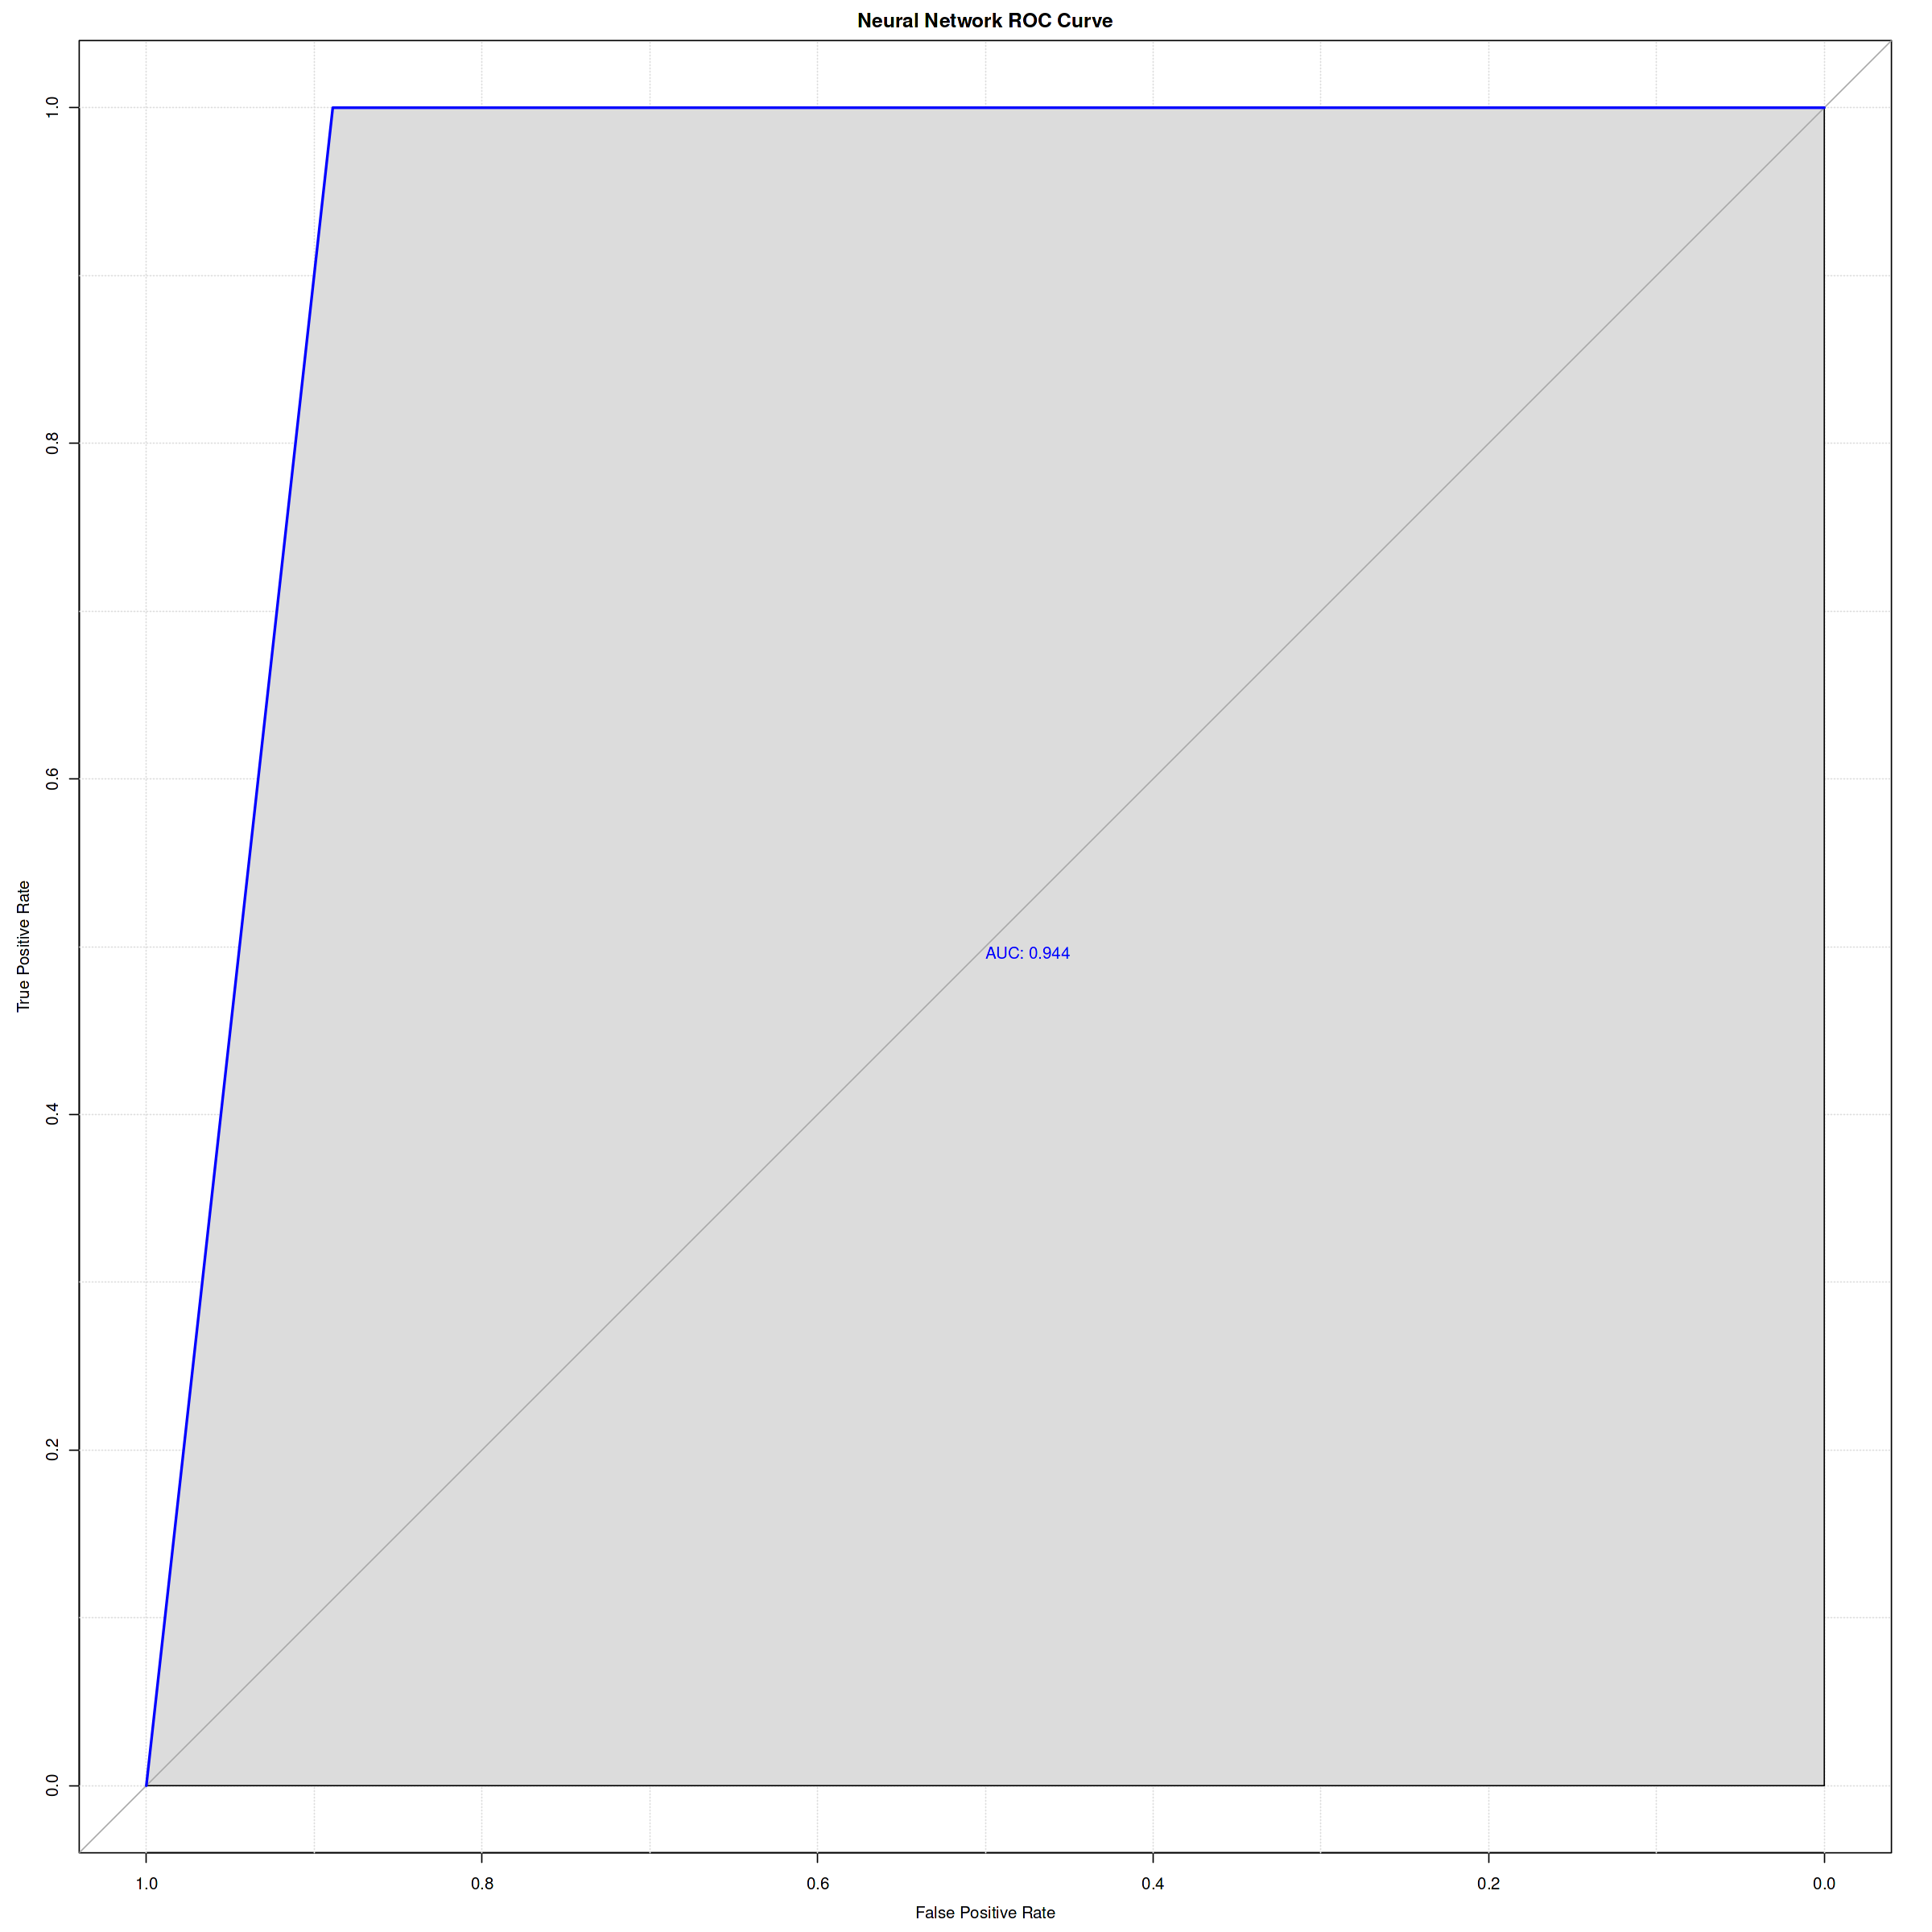

In [96]:
# Create the ROC curve
y_pred_prob <- as.numeric(test_pred)
roc_obj <- roc(Y_test, y_pred_prob)
plot(roc_obj, main = "Neural Network ROC Curve", print.auc = TRUE, auc.polygon = TRUE,
     grid = TRUE, col = "blue", lwd = 2, lty = 1,
     xlab = "False Positive Rate", ylab = "True Positive Rate")

## All the models almost the same so there isn't champion model and this deu to the nature of the data are biased towards some label over the other 

# Grid Search for Decision Tree


In [111]:
set.seed(123)

# Perform train-test split
train_index <- createDataPartition(Y, p = 0.7, list = FALSE)

# Create the training and testing datasets
X_train <- X[train_index, ]
Y_train <- Y[train_index]
X_test <- X[-train_index, ]
Y_test <- Y[-train_index]
dim(X_train)
length(Y_train)
dim(X_test)
length(Y_test)

[1] 77367    11

[1] 77367

[1] 33156    11

[1] 33156

In [100]:
# Define the parameter grid
cp_values <- seq(0.01, 0.1, by = 0.01)
param_grid <- data.frame(cp = cp_values)

# Convert x_train and x_test from matrix to data frame
x_train_df <- as.data.frame(X_train)
x_test_df <- as.data.frame(X_test)

# Train Decision Tree classifier with grid search
results <- lapply(cp_values, function(cp) {
  ctrl <- rpart.control(cp = cp)
  tree_model <- rpart(as.factor(Y_train) ~ ., data = x_train_df, control = ctrl)
  tree_pred <- predict(tree_model, newdata = x_test_df, type = "class")
  accuracy <- sum(tree_pred == Y_test) / length(Y_test) * 100
  return(list(cp = cp, accuracy = accuracy))
})

# Create an empty data frame to store the results
results_df <- data.frame(cp = numeric(length(results)), accuracy = numeric(length(results)))

# Populate the results data frame
for (i in seq_along(results)) {
  results_df[i, "cp"] <- results[[i]]$cp
  results_df[i, "accuracy"] <- results[[i]]$accuracy
}

# Find the best model based on accuracy
best_model <- results_df[which.max(results_df$accuracy), ]

# Print the best model's cp value and accuracy
cat("Best Decision Tree Model (cp =", best_model$cp, ") Accuracy:", round(best_model$accuracy, 2), "%\n")

Best Decision Tree Model (cp = 0.01 ) Accuracy: 79.81 %


# Part 2) A-

In [67]:
data <- read.csv("/kaggle/input/framingham/framingham.csv")

head(data)


,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
1,1,39,4,0,0,0,0,0,0,195,106.0,70,26.97,80,77,0
2,0,46,2,0,0,0,0,0,0,250,121.0,81,28.73,95,76,0
3,1,48,1,1,20,0,0,0,0,245,127.5,80,25.34,75,70,0
4,0,61,3,1,30,0,0,1,0,225,150.0,95,28.58,65,103,1
5,0,46,3,1,23,0,0,0,0,285,130.0,84,23.10,85,85,0
6,0,43,2,0,0,0,0,1,0,228,180.0,110,30.30,77,99,0


## Get the Gender & Age columns

In [68]:
X <- data[, 1:2]
head(X)

,male,age
,<int>,<int>
1,1,39
2,0,46
3,1,48
4,0,61
5,0,46
6,0,43


## Perform normalization for the Age column

In [69]:
X = minMaxNormalize(X,"age")
head(X)

,male,age
,<int>,<dbl>
1,1,0.1842105
2,0,0.3684211
3,1,0.4210526
4,0,0.7631579
5,0,0.3684211
6,0,0.2894737


### 1- Perform K-means with k equal 4 

In [70]:
set.seed(123)
kmeans_result <- kmeans(X, centers = 4)

# Step 4: Explore the results
cluster_assignment <- kmeans_result$cluster
cluster_centers <- kmeans_result$centers


In [71]:
table(cluster_assignment)

cluster_assignment
   1    2    3    4 
1243 1040  780 1177 

In [72]:
cluster_centers

,male,age
1,0,0.2798620
2,1,0.2887146
3,1,0.6769231
4,0,0.6673300


### 1- plotting the data as scatterd

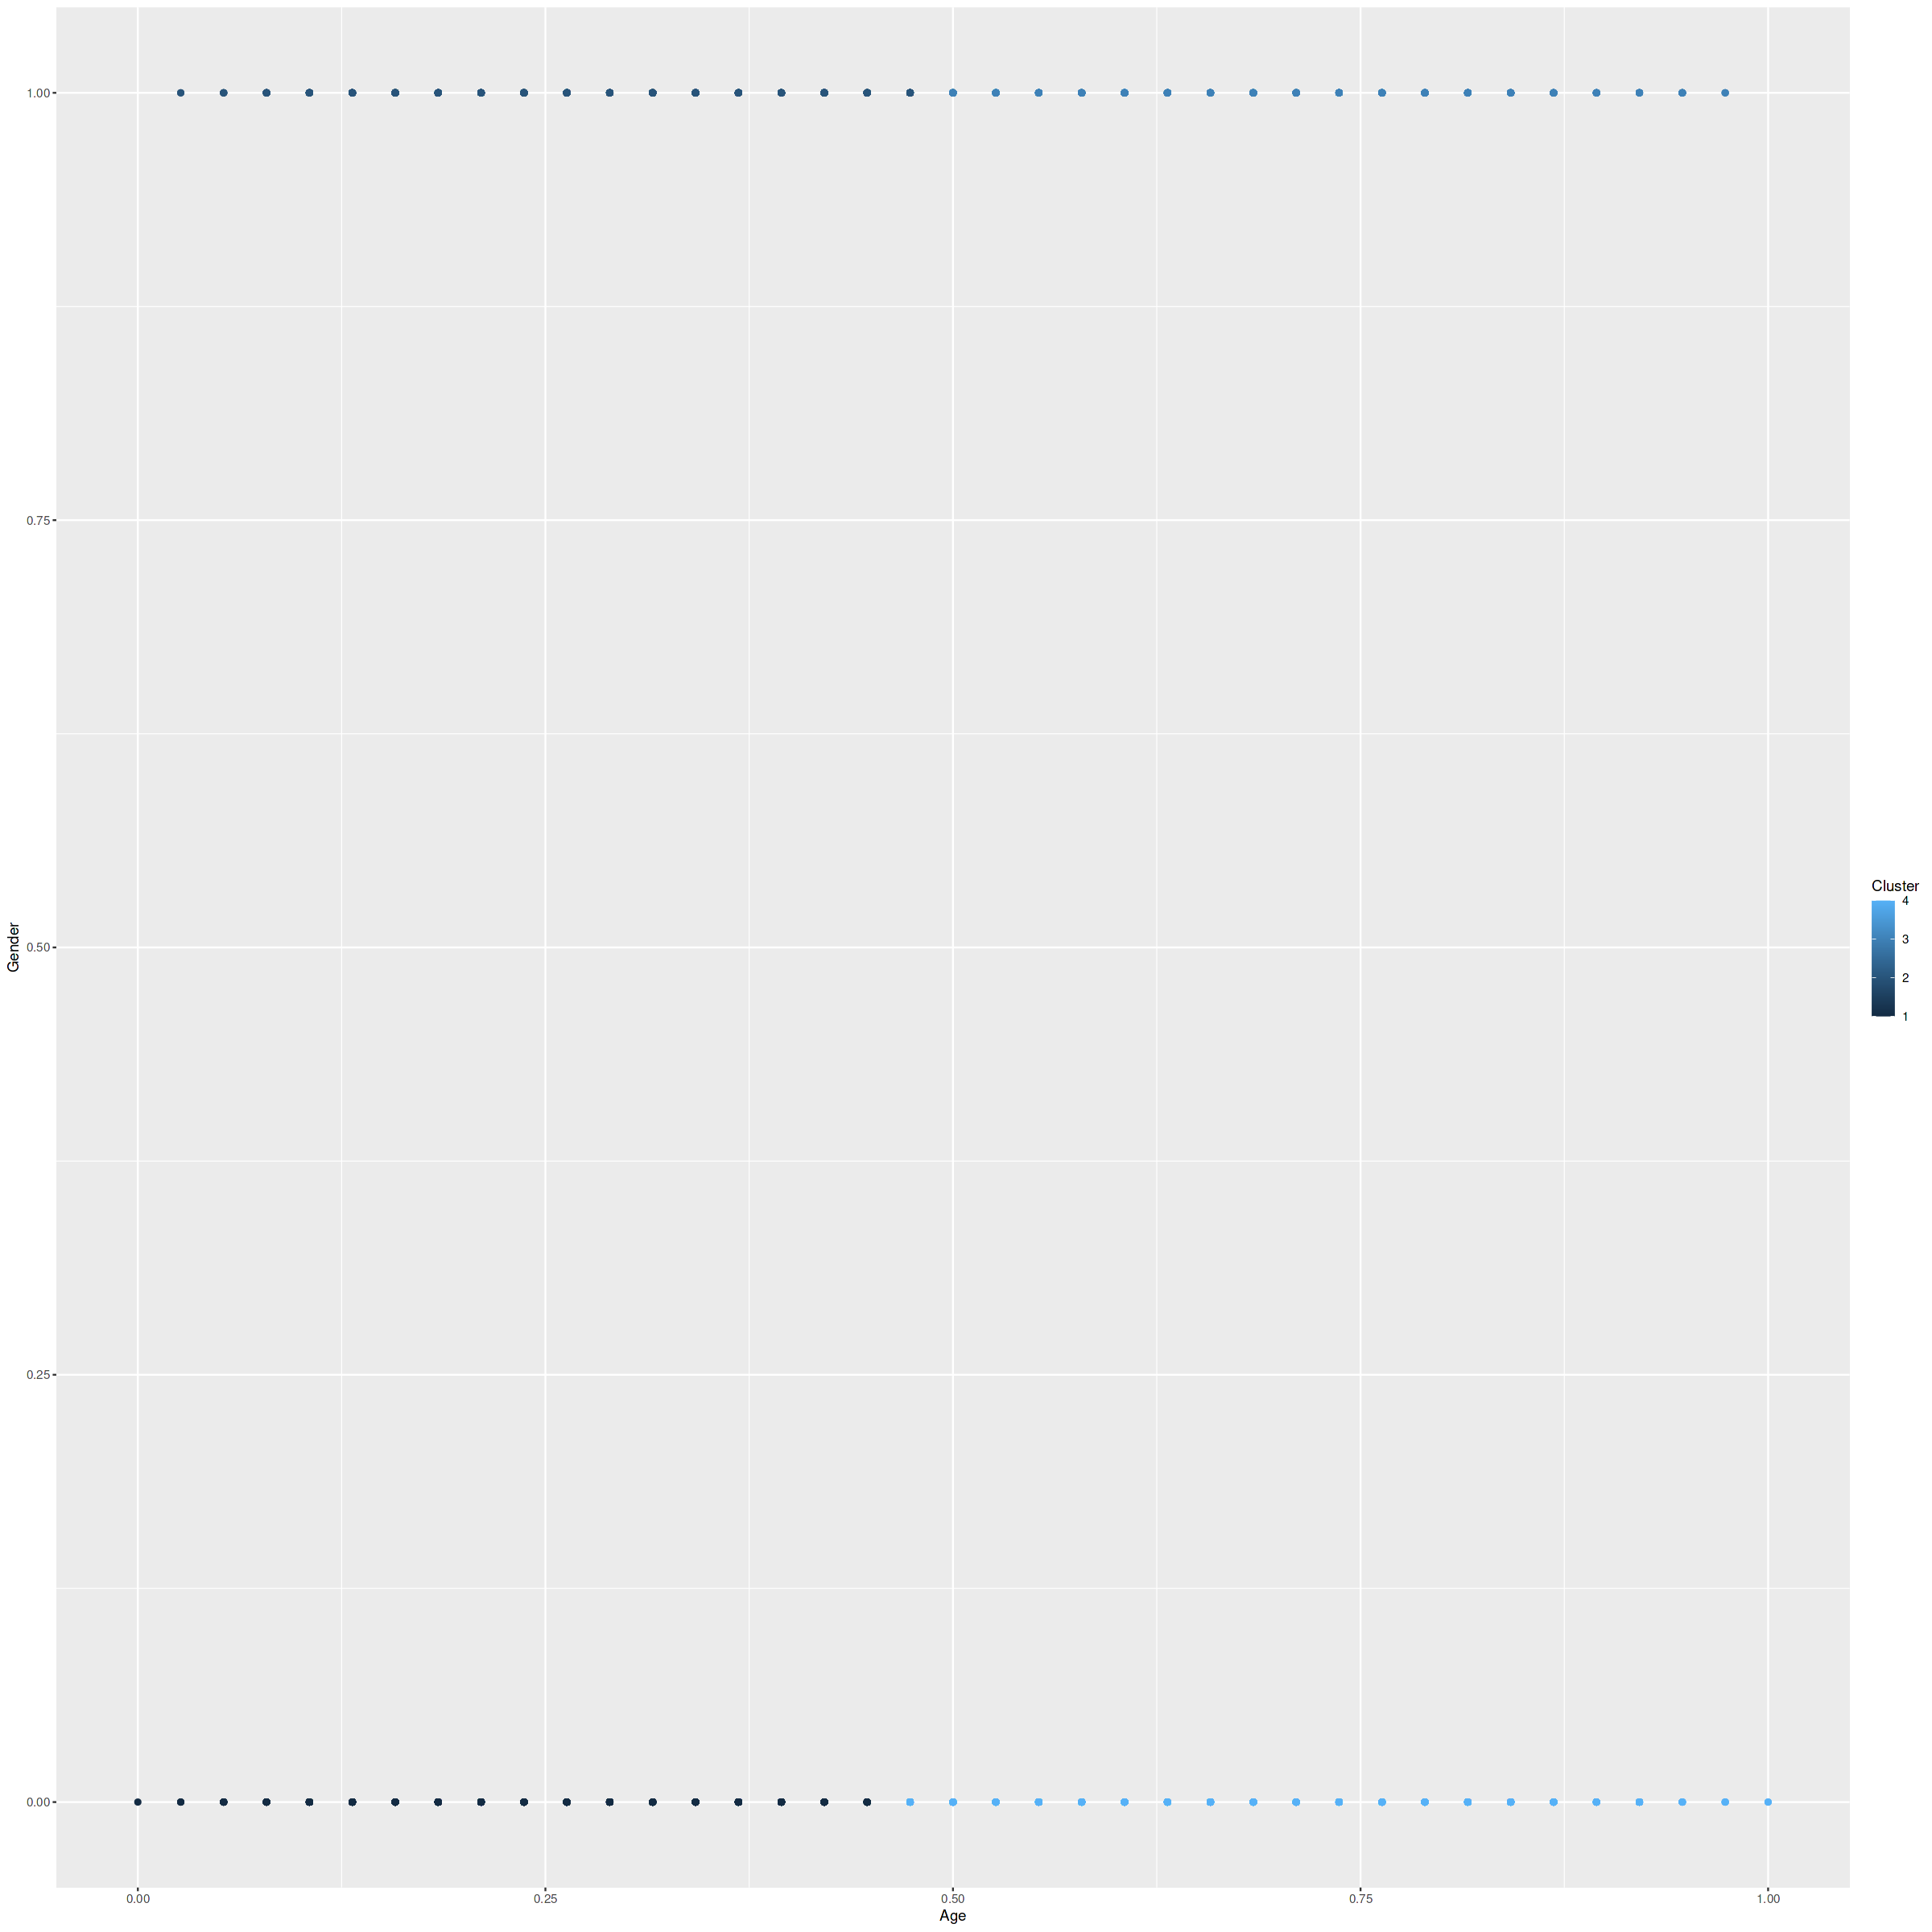

In [73]:
df <- as.data.frame(X)
df$cluster <- as.factor(cluster_assignment)

# Scatter plot with colored clusters
ggplot(df, aes(x = age, y = male, color = cluster_assignment)) +
  geom_point() +
  labs(x = "Age", y = "Gender", color = "Cluster")

### 2- plot the elbow method 

### From the plot we can see the best K for the model can be 4 or 5 clusters 

[1] 1254.52617  215.57097  124.47169   57.63725   40.50503   40.27545
 [7]   23.23110   21.33983   13.99596   11.17883

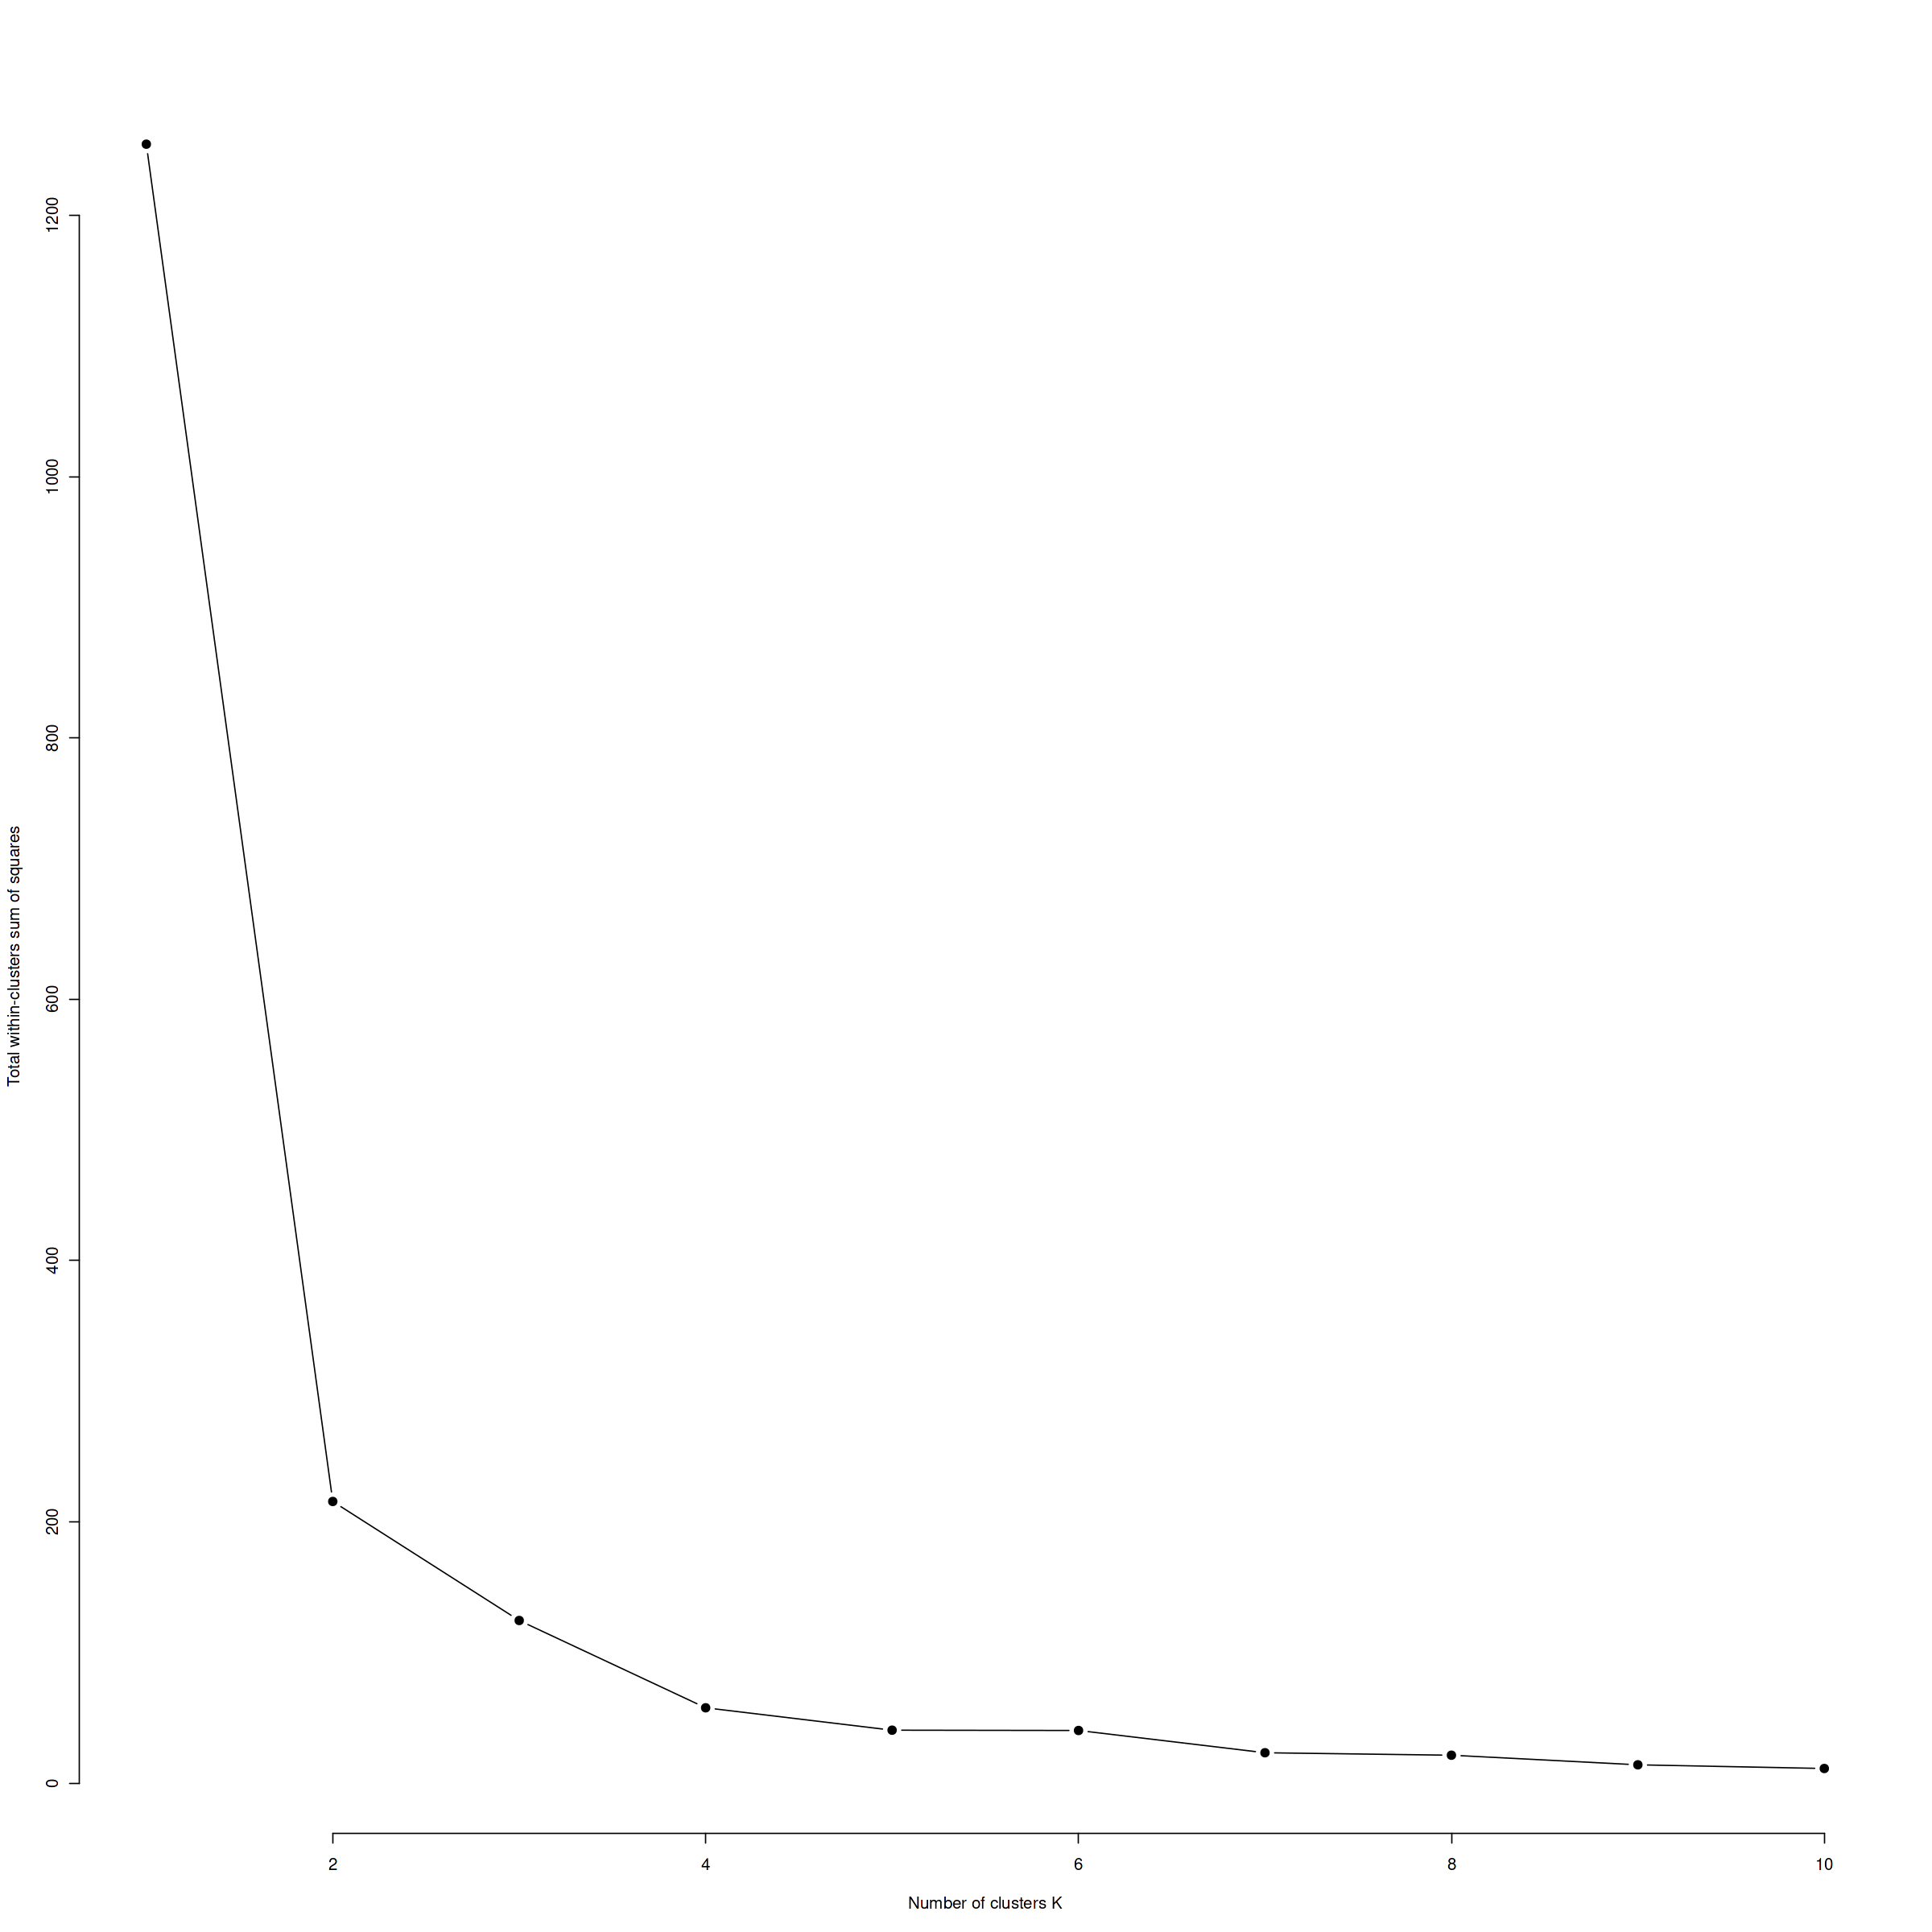

In [74]:
k.max <- 10
data <- X
wss <- sapply(1:k.max, 
              function(k){kmeans(data, k )$tot.withinss})
wss
plot(1:k.max, wss,
     type="b", pch = 19, frame = FALSE, 
     xlab="Number of clusters K",
     ylab="Total within-clusters sum of squares")

### 3- display the silhoutte score for the K equal 4 

In [75]:
library(cluster)
silhouette = silhouette(cluster_assignment , dist(X))
# Average Silhouette Coefficient
avg_silhouette <- mean(silhouette[, "sil_width"])

# Print the average Silhouette Coefficient
cat("Average Silhouette Coefficient:", avg_silhouette, "\n")

Average Silhouette Coefficient: 0.6188836 


### Calculate the silhoutte score from K equal 2 to 10 and line plot it 

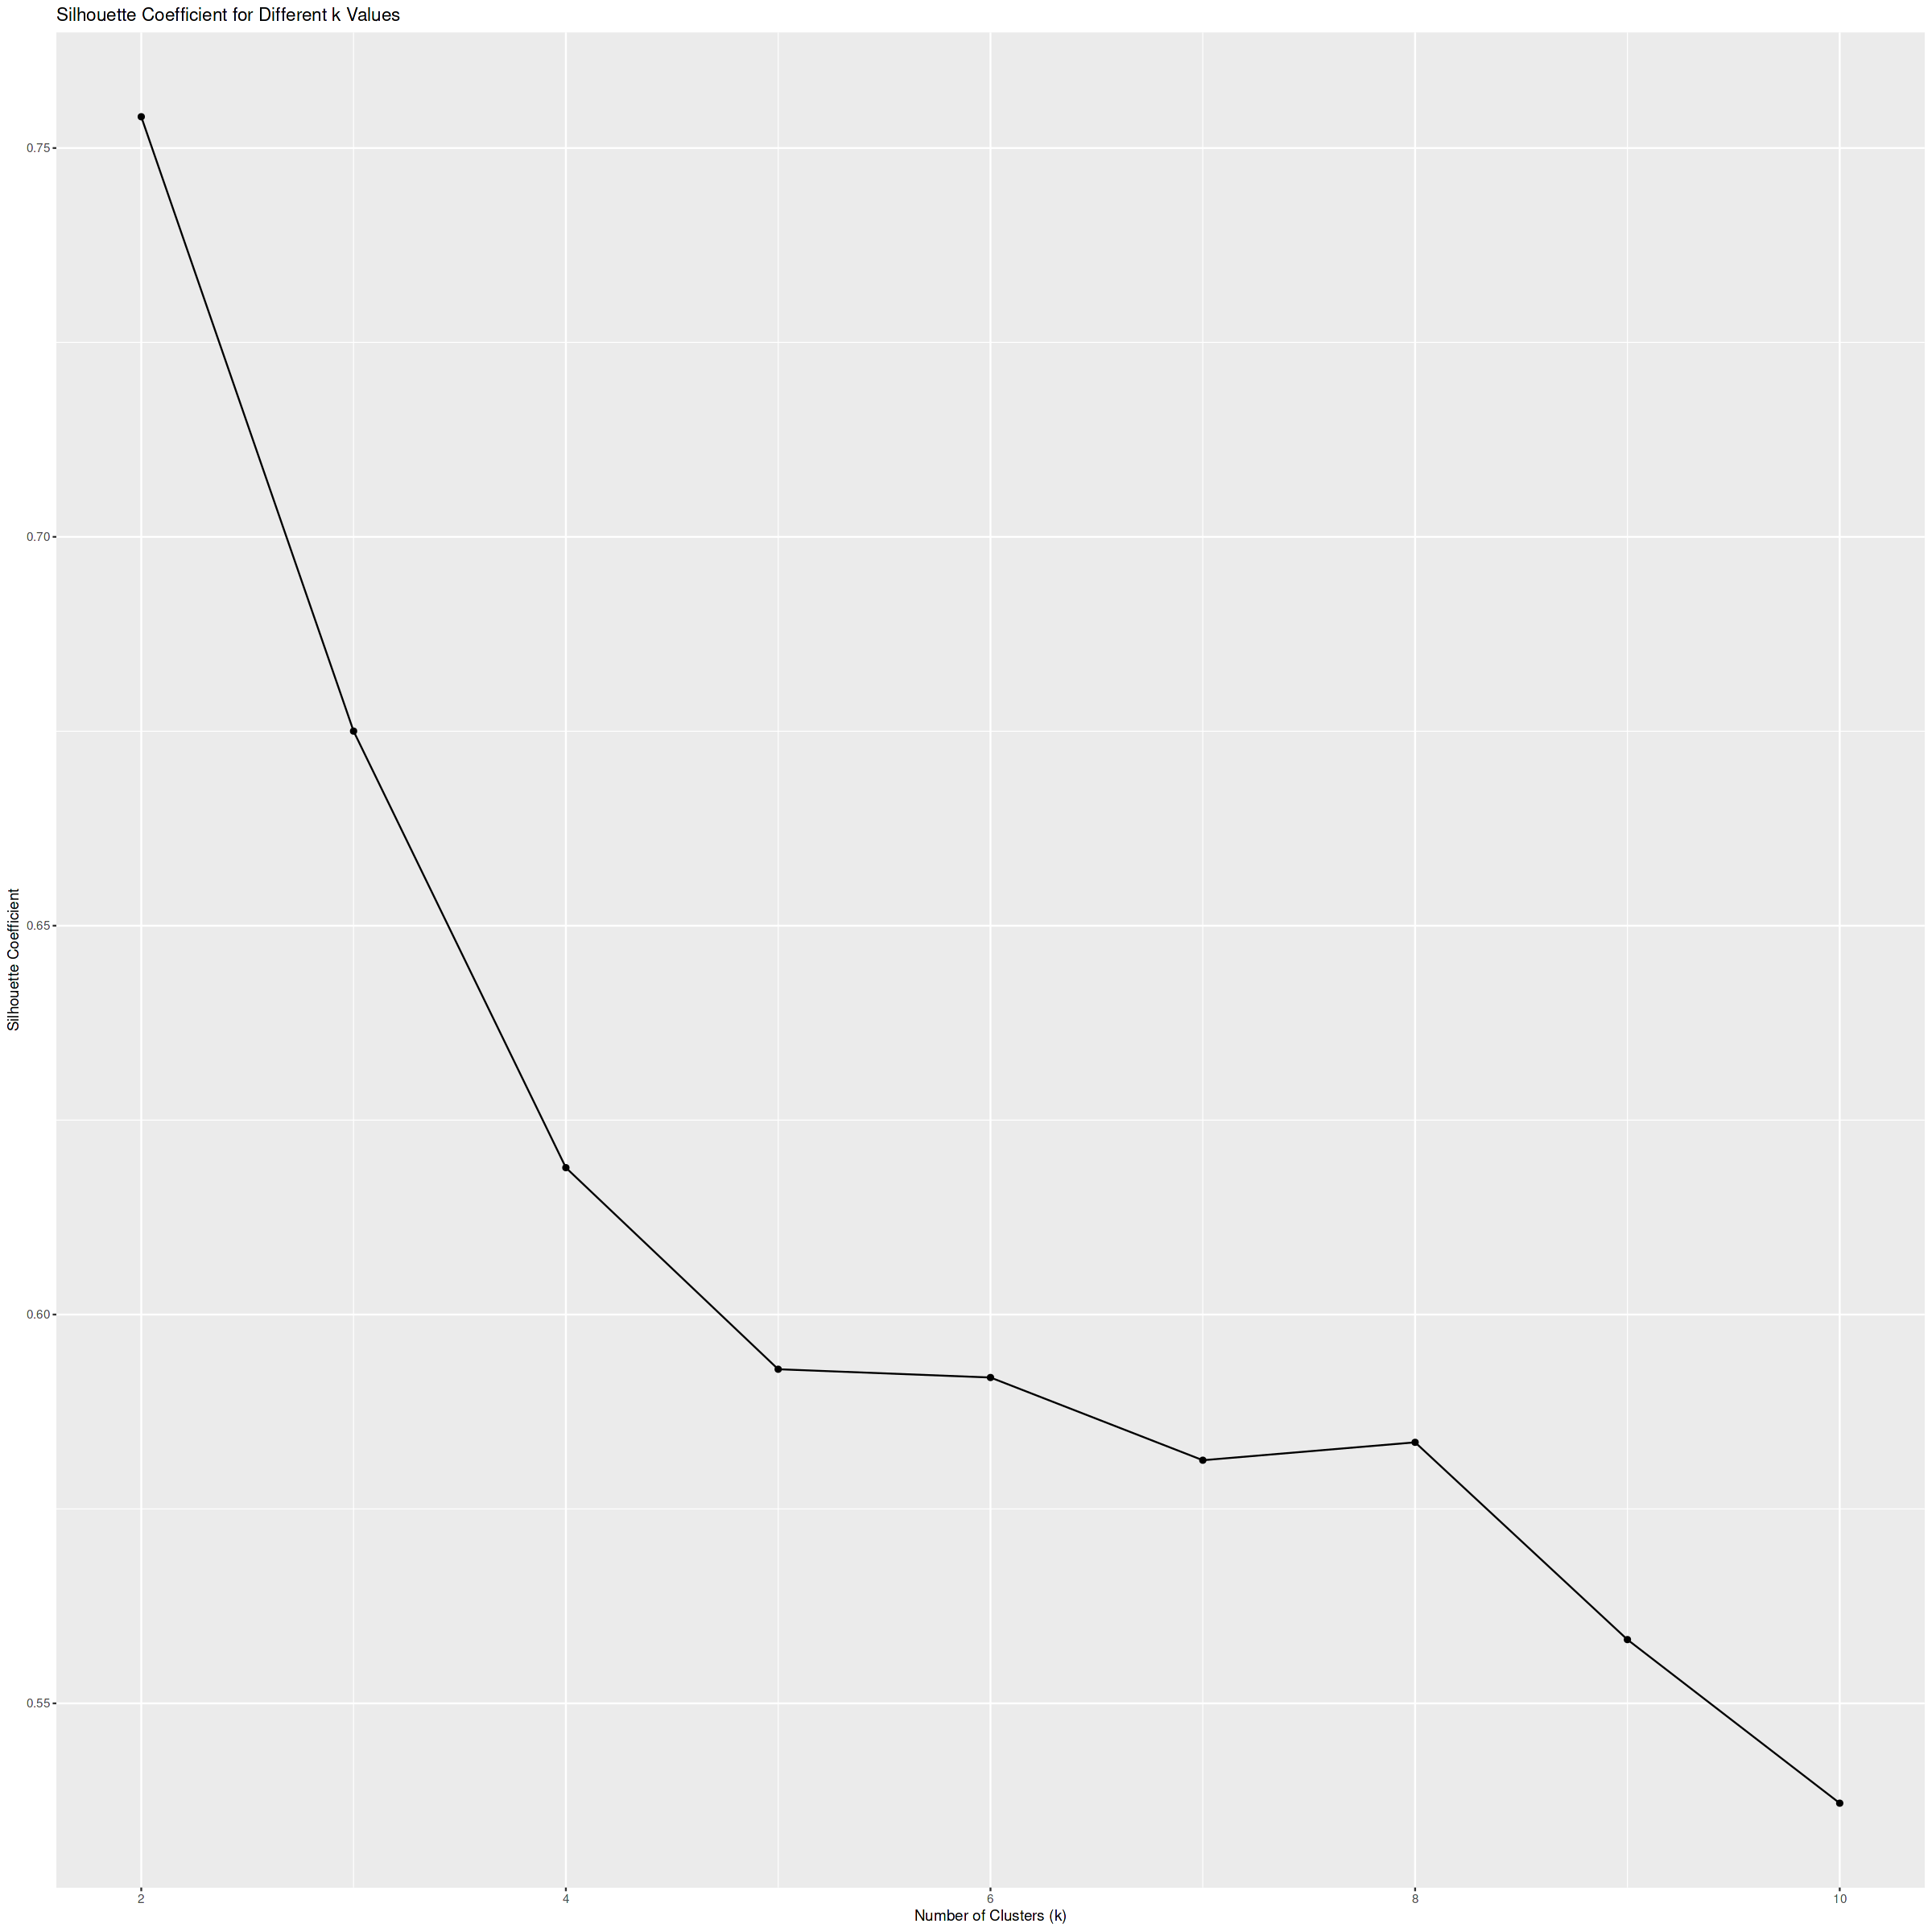

In [76]:
# Specify the range of k values
k_values <- 2:10

# Initialize a vector to store Silhouette Coefficients
silhouette_values <- numeric(length(k_values))

# Calculate Silhouette Coefficient for each value of k
for (i in seq_along(k_values)) {
  k <- k_values[i]
  set.seed(123)  # Set seed for reproducibility
  kmeans_result <- kmeans(X, centers = k)
  cluster_labels <- kmeans_result$cluster
  silhouette_values[i] <- silhouette_avg <- mean(silhouette(cluster_labels, dist(X))[, "sil_width"])
}

# Plot the Silhouette Coefficient for different k values
plot_data <- data.frame(k = k_values, silhouette = silhouette_values)

ggplot(plot_data, aes(x = k, y = silhouette)) +
  geom_line() +
  geom_point() +
  labs(x = "Number of Clusters (k)", y = "Silhouette Coefficient") +
  ggtitle("Silhouette Coefficient for Different k Values")